Base repo of data: https://github.com/mlsedigital/SPL-open-data

Great xyz data dict: https://www.inpredictable.com/2021/01/nba-player-shooting-motions-data-dump.html


## Ultimate Goals:
* Find optimal shooting form/release point
  * Include the feedback system based on optimal shooting form and release point
  * ### Use shooting meter from NBA 2k to show good vs bad releases and body movements
  * ^use the motions that:
    * produce good results (a make or enough kinetic energy for a near make)
    * are within certain boundaries where the player is comfortable AND in right shooting form
    * are within certain ranges (this inch to this inch is the best motion area for this player, etc.)
    * Compared to Popular Shooters to make recommendations to shoot more like someone like Klay Thompson or Buddy Hield (see if the data from the xyz data dictionary has good shooters to make recommendations to shoot like them)
* Exhaustion levels and optimal energy max and min
* Shot outcome prediction


1. Finding Optimal Shooting Form/Release Point

    Detailed Analysis of Body Movements: Include analysis of body kinematics (positions and velocities of limbs) at the time of release. Use joint coordinates to extract features like elbow angle, shoulder rotation, and wrist flexion at the release frame.
    Machine Learning for Form Classification: Train a model to classify "good" vs. "bad" shooting forms using successful shot data (makes or near-makes) and compare them against unsuccessful shots.
    Feedback Mechanism: Implement a feedback system that suggests adjustments based on the comparison of current shooting mechanics to historical optimal ones.

2. Shooting Meter Simulation (NBA 2K-Style)

    Visual Feedback System: Develop a visualization tool that overlays a “meter” on shot video frames, indicating the quality of the release in real-time. This can be based on a scoring function derived from the shooting form features and ball dynamics.
    Comfort Zone Identification: Use clustering algorithms (e.g., K-means) to identify comfortable ranges of motion based on historical shooting data for individual players.

3. Shot Outcome Prediction

    Feature Engineering for Outcome Modeling: Include additional features such as:
        Kinetic Energy Calculation: KE=12mv2KE=21​mv2 to see if the ball had sufficient energy for a make.
        Entry Angle and Trajectory Analysis: Analyze whether the angle at which the ball approaches the hoop aligns with optimal scoring trajectories.
    Model Development: Build a machine learning model (e.g., logistic regression, XGBoost) that predicts shot outcomes based on ball speed, entry angle, release point, and body dynamics.
    Training with Data Augmentation: Use synthetic data generation to include a wide variety of shot scenarios.

4. Exhaustion Levels and Energy Management

    Tracking Player Movements: Use the coordinates of major joints (e.g., knees, hips) to estimate a player's exertion level using metrics like the average vertical displacement over time.
    Velocity and Acceleration Patterns: Monitor changes in the velocity and acceleration of the player's body parts throughout a game to detect fatigue.
    Feature Integration: Create features such as average speed and distance covered leading up to the shot to include in the predictive model.

5. shot simulator: 
    if by these metrics we can simulate the shot to a nearby hoop. We can set the hoop in a set location (or when using spatial, we'd pick the location), and set it up to virtualize the experience with yolo/opencv where when you make those motions to show shooting motion, you can show where the ball might go (even without a ball in hand).

# ML Dataset Pipeline:
    - categorize data
    - multicollinearity/feature importances = feature selection
    - preprocessing suggestions, datasets, preprocessing with strict guidelines
    - ml model selection
    - ml model testing
    - ml data inverse transform
    - ml model prediction
    - live prediction and re-calculate the dataset formulas for when new data attaches
    - get optimal ranges for the angles (knee/wrist/elbow) and input them into the meters
    - input the meters into a video for optimal angles
    - add in ml classification with re-calculation
    - live camera feed with this? 
      - streamlit example of how this works with li


In [8]:
%%writefile ml/feature_selection/multicollinearity_checker.py

import pandas as pd
import numpy as np

def check_multicollinearity(df, threshold=0.8, debug=False):
    """
    Identifies pairs of features with correlation above the specified threshold.
    Args:
        df (DataFrame): DataFrame containing numerical features.
        threshold (float): Correlation coefficient threshold.
        debug (bool): If True, prints debugging information.
    Returns:
        DataFrame: Pairs of features with high correlation.
    """
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if debug:
        print(f"Computing correlation matrix for {len(numeric_df.columns)} numerical features...")

    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify highly correlated features
    highly_correlated = [
        (column, idx, upper.loc[column, idx])
        for column in upper.columns
        for idx in upper.index
        if (upper.loc[column, idx] > threshold)
    ]

    multicollinearity_df = pd.DataFrame(highly_correlated, columns=['Feature1', 'Feature2', 'Correlation'])

    if debug:
        if not multicollinearity_df.empty:
            print(f"Found {len(multicollinearity_df)} pairs of highly correlated features:")
            print(multicollinearity_df)
        else:
            print("No highly correlated feature pairs found.")

    return multicollinearity_df




if __name__ == "__main__":
    import pickle
    # Load the category bin configuration
    with open('../../data/model/pipeline/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)
    
    # Feature selection based on multi collinearity and random forest importance selection
    target_variable = 'result'
    correlation_threshold = 0.8
    debug = True

    # Remove columns to address collinearity
    drop_features = [ 'L_KNEE_min_power', 'L_HIP_max_power']
    
    # Step 1: Check for multicollinearity
    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df, threshold=correlation_threshold, debug=debug)

    # Step 2: Handle multicollinearity
    if not multicollinearity_df.empty:
        for index, row in multicollinearity_df.iterrows():
            feature1, feature2, correlation = row['Feature1'], row['Feature2'], row['Correlation']
            print(f"High correlation ({correlation}) between '{feature1}' and '{feature2}'.")
    else:
        print("No multicollinearity issues detected.")


Overwriting ml/feature_selection/multicollinearity_checker.py


In [4]:
# %%writefile ml/feature_selection/feature_importance_calculator.py
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import logging
import pickle
from typing import Optional, List, Dict, Any, Tuple, Union
import numpy as np
from pathlib import Path
import os

def calculate_feature_importance(
    df: pd.DataFrame,
    target_variable: Union[str, List[str]],
    n_estimators: int = 100,
    random_state: int = 42,
    debug: bool = False
) -> pd.DataFrame:
    """
    Calculates feature importance using a Random Forest model.
    
    Args:
        df (DataFrame): Input DataFrame.
        target_variable (str or list of str): Target column name or a list with a single target column.
        n_estimators (int): Number of trees in the forest.
        random_state (int): Random seed.
        debug (bool): If True, prints debugging information.
    
    Returns:
        DataFrame: Feature importances.
    
    Note:
        If target_variable is passed as a list, it must contain only one element.
    """
    # Normalize the target variable: if provided as a list, extract the single string.
    if isinstance(target_variable, list):
        if len(target_variable) == 1:
            target = target_variable[0]
        else:
            raise ValueError("calculate_feature_importance supports only a single target variable.")
    else:
        target = target_variable

    # Drop the target column from predictors and extract the target variable column.
    X = df.drop(columns=[target])
    y = df[target]
    
    # If y is a DataFrame (e.g. if someone mistakenly passed a list with more than one column),
    # you might need to extract a Series. Here, we assume y is a Series.
    if isinstance(y, pd.DataFrame):
        # If a single-column DataFrame, convert to Series.
        if y.shape[1] == 1:
            y = y.iloc[:, 0]
        else:
            raise ValueError("The target variable DataFrame should contain only one column.")

    # Encode target variable if necessary
    if y.dtype == 'object' or str(y.dtype) == 'category':
        if debug:
            print(f"Target variable '{target}' is categorical. Encoding labels.")
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Separate categorical and numerical features
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    if debug:
        print(f"Categorical columns: {categorical_cols}")
        print(f"Numerical columns: {numeric_cols}")

    # Encode categorical features if present
    if categorical_cols:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_encoded = ohe.fit_transform(X[categorical_cols])
        X_encoded_df = pd.DataFrame(
            X_encoded,
            columns=ohe.get_feature_names_out(categorical_cols),
            index=X.index
        )
        X = pd.concat([X[numeric_cols], X_encoded_df], axis=1)

    # Select the model based on the type of y
    model = (
        RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        if y.dtype in ['int64', 'float64'] else
        RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    )

    if debug:
        print(f"Training Random Forest model with {n_estimators} estimators...")

    model.fit(X, y)

    # Calculate feature importances and return them as a DataFrame.
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    if debug:
        print("Feature Importances:")
        print(feature_importances)

    return feature_importances


def manage_features(
    mode: str,
    features_df: Optional[pd.DataFrame] = None,
    ordinal_categoricals: Optional[List[str]] = None,
    nominal_categoricals: Optional[List[str]] = None,
    numericals: Optional[List[str]] = None,
    y_variable: Optional[Union[str, List[str]]] = None,
    paths: Optional[Dict[str, str]] = None,
    base_dir: Optional[Union[str, Path]] = None
) -> Optional[Dict[str, Any]]:
    """
    Save or load features and metadata.

    Parameters:
        mode (str): "save" or "load".
        features_df (pd.DataFrame, optional): DataFrame containing features (required for "save").
        ordinal_categoricals (list, optional): List of ordinal categorical features.
        nominal_categoricals (list, optional): List of nominal categorical features.
        numericals (list, optional): List of numerical features.
        y_variable (str or list of str, optional): Target variable.
        paths (dict, optional): Dictionary mapping item keys to file names.
        base_dir (str or Path, optional): Base directory where files should be saved or loaded from.

    Returns:
        For "load" mode, returns a dictionary of loaded items; for "save" mode, returns None.
    """
    # Ensure base_dir is a Path object and resolve it
    if base_dir is None:
        base_dir = Path.cwd()
    else:
        base_dir = Path(base_dir).resolve()

    # Set default file names joined with the base directory.
    default_paths = {
        'features': str(base_dir / 'final_ml_df_selected_features_columns.pkl'),
        'ordinal_categoricals': str(base_dir / 'ordinal_categoricals.pkl'),
        'nominal_categoricals': str(base_dir / 'nominal_categoricals.pkl'),
        'numericals': str(base_dir / 'numericals.pkl'),
        'y_variable': str(base_dir / 'y_variable.pkl')
    }

    # If a paths dictionary is provided, update the defaults.
    if paths:
        default_paths.update(paths)

    try:
        if mode == 'save':
            if features_df is None:
                raise ValueError("features_df must be provided in 'save' mode.")

            data_to_save = {
                'features': features_df.columns.tolist(),
                'ordinal_categoricals': ordinal_categoricals,
                'nominal_categoricals': nominal_categoricals,
                'numericals': numericals,
                'y_variable': y_variable
            }

            # Create necessary directories and save each item.
            for key, file_path in default_paths.items():
                file_path_obj = Path(file_path)
                file_path_obj.parent.mkdir(parents=True, exist_ok=True)
                with open(file_path_obj, 'wb') as f:
                    pickle.dump(data_to_save[key], f)
                print(f"✅ {key.replace('_', ' ').capitalize()} saved to {file_path_obj}")

        elif mode == 'load':
            loaded_data = {}
            for key, file_path in default_paths.items():
                file_path_obj = Path(file_path)
                if not file_path_obj.exists():
                    print(f"❌ {key.replace('_', ' ').capitalize()} file not found at {file_path_obj}")
                    loaded_data[key] = None
                else:
                    with open(file_path_obj, 'rb') as f:
                        loaded_data[key] = pickle.load(f)
                    print(f"✅ {key.replace('_', ' ').capitalize()} loaded from {file_path_obj}")
            return loaded_data

        else:
            raise ValueError("Mode should be either 'save' or 'load'.")

    except Exception as e:
        print(f"❌ Error during '{mode}' operation: {e}")
        if mode == 'load':
            return {key: None for key in default_paths.keys()}
        

if __name__ == "__main__":
    # For testing purposes: load dataset and run feature importance.

    final_ml_features_path = str(Path("../../data/preprocessor") / "features_info" / "final_ml_df_selected_features_columns.pkl")
    # (Other paths omitted for brevity.)

    file_path = "../../data/processed/final_ml_dataset.csv"
    final_ml_df = pd.read_csv(file_path)

    # For demonstration, set the target variable as a list.
    target_variable = ['result']
    correlation_threshold = 0.8
    debug = True

    # (Assume check_multicollinearity is defined elsewhere.)
    from ml.feature_selection.multicollinearity_checker import check_multicollinearity

    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df, threshold=correlation_threshold, debug=debug)

    if multicollinearity_df.empty:
        print("No multicollinearity issues detected.")
    else:
        for _, row in multicollinearity_df.iterrows():
            print(f"High correlation ({row['Correlation']}) between '{row['Feature1']}' and '{row['Feature2']}'.")

    # Calculate feature importance.
    print("\nCalculating Feature Importance...")
    feature_importances = calculate_feature_importance(
        final_ml_df, target_variable=target_variable, n_estimators=100, random_state=42, debug=debug
    )
    print("\nFinal Feature Importances:")
    print(feature_importances.to_string(index=False))

    
    #Final Decisions: 
    # Features recommended for dropping
    features_to_drop = [
        'peak_height_relative'
    ]
    print(f"Dropped features (for redundancy or multicollinearity): {', '.join(features_to_drop)}")
    

    # Define categories and column names
    ordinal_categoricals = []
    nominal_categoricals = [] #'player_estimated_hand_length_cm_category'
    numericals = [        'release_ball_direction_x' ,'release_ball_direction_z', 'release_ball_direction_y',
        'elbow_release_angle', 'elbow_max_angle',
        'wrist_release_angle', 'wrist_max_angle',
        'knee_release_angle', 'knee_max_angle',
        'release_ball_speed', 'calculated_release_angle',
        'release_ball_velocity_x', 'release_ball_velocity_y','release_ball_velocity_z']
    y_variable = ['result']
    final_keep_list = ordinal_categoricals + nominal_categoricals + numericals + y_variable
    
    # Apply the filter to keep only these columns
    final_ml_df_selected_features = final_ml_df[final_keep_list]
    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # Save feature names to a file
    with open(final_ml_features_path, 'wb') as f:
        pickle.dump(final_ml_df_selected_features.columns.tolist(), f)

    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # You might also load your config and then get base_dir from config.paths.processed_data_dir joined with config.paths.data_dir
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    paths = {
        "features": str(base_dir / "final_ml_df_selected_features_columns.pkl"),
        "ordinal_categoricals": str(base_dir / "ordinal_categoricals.pkl"),
        'nominal_categoricals': str(base_dir /'nominal_categoricals.pkl'),
        'numericals': str(base_dir /'numericals.pkl'),
        'y_variable': str(base_dir /'y_variable.pkl')
    }

    # Save features and metadata
    manage_features(
        mode='save',
        features_df=final_ml_df_selected_features,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        y_variable=y_variable,
        paths=paths,
        base_dir=base_dir
    )

    # Later, load features and metadata
    loaded = manage_features(
        mode='load',
        paths=paths,
        base_dir=base_dir
    )
    print("\n📥 Loaded Data from:", base_dir)
    print("\n📥 Loaded Data:")
    print("Features:", loaded.get('features'))
    print("Ordinal Categoricals:", loaded.get('ordinal_categoricals'))
    print("Nominal Categoricals:", loaded.get('nominal_categoricals'))
    print("Numericals:", loaded.get('numericals'))
    print("Y Variable:", loaded.get('y_variable'))



Checking for Multicollinearity...
Computing correlation matrix for 132 numerical features...
Found 431 pairs of highly correlated features:
                   Feature1                Feature2  Correlation
0         L_ANKLE_max_power       L_ANKLE_std_power     0.925380
1         R_ANKLE_max_power       R_ANKLE_std_power     0.909245
2          L_KNEE_max_power        R_KNEE_max_power     0.858762
3          L_KNEE_avg_power        R_KNEE_avg_power     0.918763
4          L_KNEE_avg_power         L_HIP_avg_power     0.804101
..                      ...                     ...          ...
426  L_1STFINGER_energy_std  L_5THFINGER_energy_std     0.989249
427  L_1STFINGER_energy_std  R_5THFINGER_energy_std     0.962547
428  R_1STFINGER_energy_std  L_5THFINGER_energy_std     0.934655
429  R_1STFINGER_energy_std  R_5THFINGER_energy_std     0.995210
430  L_5THFINGER_energy_std  R_5THFINGER_energy_std     0.939738

[431 rows x 3 columns]
High correlation (0.9253798811958034) between 'L_ANKLE_

https://chatgpt.com/c/67583ce6-82ac-8012-b1d7-c415f658caa0

In [5]:
%%writefile ml/config/config_models.py
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
from omegaconf import OmegaConf
from pathlib import Path
class FeaturesConfig(BaseModel):
    ordinal_categoricals: List[str] = []
    nominal_categoricals: List[str] = []
    numericals: List[str]
    y_variable: List[str]

class PathsConfig(BaseModel):
    data_dir: str = "../../data/preprocessor"  # Unified base for preprocessor outputs
    raw_data: str = "../processed/final_ml_dataset.csv"
    processed_data_dir: str = "processed"
    features_metadata_file: str = "features_info/final_ml_df_selected_features_columns.pkl"
    predictions_output_dir: str = "../../data/predictions"
    config_file: str = "../../data/model/preprocessor_config/preprocessor_config.yaml"
    log_dir: str = "../../data/preprocessor/logs"
    model_save_base_dir: str = "../../data/model"
    transformers_save_base_dir: str = "../../data/preprocessor/transformers"
    plots_output_dir: str = "../../data/preprocessor/plots"
    training_output_dir: str = "../../data/preprocessor/training_output"
    log_file: Optional[str] = "../../data/preprocessor/prediction.log"


class ModelsConfig(BaseModel):
    selected_models: List[str] = Field(default_factory=lambda: ["XGBoost", "Random Forest", "Decision Tree, CatBoost"])
    selection_metric: str = "Log Loss"
    Tree_Based_Classifier: Optional[Dict] = {}

class LoggingConfig(BaseModel):
    level: str = "INFO"
    debug: bool = False

class AppConfig(BaseModel):
    # Make sure this is now a plain list
    model_types: List[str]
    model_sub_types: Dict[str, List[str]]
    features: FeaturesConfig
    paths: PathsConfig
    models: ModelsConfig
    logging: LoggingConfig = LoggingConfig()   # default provided if missing
    execution: Optional[Dict] = {}


def load_config(config_path: Path) -> AppConfig:
    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)
    print("DEBUG: Loaded configuration dictionary:", cfg_dict)
    app_config = AppConfig(**cfg_dict)
    print(f"[Config Loader] ✅ Successfully loaded configuration from {config_path}")
    return app_config


if __name__ == "__main__":
    import json
    config = load_config(Path('../../data/model/preprocessor_config/preprocessor_config.yaml'))
    print(json.dumps(config.model_dump(), indent=2))

Overwriting ml/config/config_models.py


In [7]:
%%writefile ml/config/config_loader.py
from pathlib import Path
from omegaconf import OmegaConf
from ml.config.config_models import AppConfig

def load_config(config_path: Path) -> AppConfig:
    """
    Load the configuration from a YAML file using OmegaConf and convert it into a typed AppConfig object.
    
    Args:
        config_path (Path): Path to the YAML configuration file.
    
    Returns:
        AppConfig: A validated configuration instance.
    """
    try:
        # Load the YAML configuration with OmegaConf
        cfg = OmegaConf.load(config_path)
        # Convert the DictConfig to a regular dict (resolving variables, if any)
        cfg_dict = OmegaConf.to_container(cfg, resolve=True)
        # Use the Pydantic model for validation and type safety.
        app_config = AppConfig(**cfg_dict)
        print(f"[Config Loader] ✅ Successfully loaded configuration from {config_path}")
        return app_config
    except Exception as e:
        print(f"[Config Loader] ❌ Failed to load configuration: {e}")
        raise


Overwriting ml/config/config_loader.py


In [1]:
%%writefile ml/train_utils/train_utils.py


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration

import joblib
import os
import logging
import pandas as pd
from pathlib import Path
from typing import Any

# Local imports
from ml.feature_selection.data_loader_post_select_features import load_selected_features_data

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    logger.info(f"Predictions: {y_pred}")
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Log Loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    with open(save_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    return metrics


def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model and preprocessing steps to disk.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - preprocessing_steps: Dictionary of preprocessing objects (e.g., encoders, scalers).
    - save_dir: Directory to save the model and preprocessing steps.
    """
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")

    # Save the model
    joblib.dump(model, model_path)
    logger.info(f"Model saved to {model_path}")


def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model


# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        logger.info(f"PCA explained variance ratios: {explained_variance}")
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )
    logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")

    # Flatten the grid arrays and combine into a single array
    grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
    logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        logger.info("Inverse transforming grid points back to original feature space for prediction.")
        grid_points_original = pca.inverse_transform(grid_points_2d)
        logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
        # Predict on the grid points in original feature space
        try:
            Z = model.predict(grid_points_original)
        except ValueError as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        Z = model.predict(grid_points_original)

    Z = Z.reshape(xx.shape)
    logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
    plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
    plt.show()

# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for CatBoost
def tune_catboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for CatBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'iterations': Integer(100, 500),
        'depth': Integer(3, 10),
        'l2_leaf_reg': Real(1, 10),
        'bagging_temperature': Real(0, 1),
        'border_count': Integer(32, 255)
    }
    logger.info(f"Parameter space for CatBoost: {param_space}")

    # Note: CatBoostClassifier might print a lot of output by default.
    # We disable verbose by setting verbose=0.
    search = BayesSearchCV(
        CatBoostClassifier(random_state=42, thread_count=-1, verbose=0),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found for CatBoost: {search.best_params_}")
    logger.info(f"Best cross-validation score for CatBoost: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_




def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: Path,
    classification_save_path: Path,
    tuning_results_save: Path,
    selected_models: Any,
    use_pca: bool = False
):
    """
    Streamlined function for model tuning, evaluation, and saving the best model.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        "XGBoost": tune_xgboost,
        "Random Forest": tune_random_forest,
        "Decision Tree": tune_decision_tree,
        "CatBoost": tune_catboost
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Ensure model_save_dir exists
    model_save_dir.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Ensured that the model save directory '{model_save_dir}' exists.")

    # Define metric key mapping
    metric_key_mapping = {
        "log loss": "Log Loss",
        "accuracy": "Accuracy",
        "precision": "Precision",
        "recall": "Recall",
        "f1 score": "F1 Score",
        "roc auc": "ROC AUC"
    }

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_key = metric_key_mapping.get(selection_metric.lower(), selection_metric)
            metric_value = metrics.get(metric_key)

            # Debugging
            logger.debug(f"Selection Metric Key: {metric_key}")
            logger.debug(f"Available Metrics: {metrics.keys()}")

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

            # Add feature importance plots for XGBoost
            if model_name.lower() == "xgboost":
                logger.info("Generating feature importance plots for XGBoost...")
                try:
                    xgb.plot_importance(best_model, importance_type="weight")
                    plt.title("Feature Importance by Weight")
                    plt.show()

                    xgb.plot_importance(best_model, importance_type="cover")
                    plt.title("Feature Importance by Cover")
                    plt.show()

                    xgb.plot_importance(best_model, importance_type="gain")
                    plt.title("Feature Importance by Gain")
                    plt.show()
                except Exception as e:
                    logger.error(f"Error generating feature importance plots: {e}")
        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model information
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            save_model(best_model, best_model_name, save_dir=model_save_dir)
            logger.info(f"✅ Model '{best_model_name}' saved successfully in '{model_save_dir}'.")
        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated

        # Add Best Model info to tuning_results
        tuning_results["Best Model"] = {
            "model_name": best_model_name,
            "metric_value": best_metric_value,
            "path": str(Path(model_save_dir) / best_model_name.replace(" ", "_") / 'trained_model.pkl')
        }
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with tuning_results_save.open("w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")

Overwriting ml/train_utils/train_utils.py


2025-02-06 10:58:49,508 - INFO - ✅ Loaded dataset from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\..\..\data\processed\final_ml_dataset.csv. Shape: (125, 140)
2025-02-06 10:58:49,510 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.
2025-02-06 10:58:49,510 - INFO - Starting: Final Preprocessing Pipeline in 'train' mode.
2025-02-06 10:58:49,510 [INFO] Step: filter_columns
2025-02-06 10:58:49,510 - INFO - Step: filter_columns
2025-02-06 10:58:49,512 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-02-06 10:58:49,512 - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)
2025-02-06 10:58:49,513 [INFO] ✅ Column filtering completed successfully.
2025-02-06 10:58:49,513 - INFO - ✅ Column filtering completed successfully.
2025-02-06 10:58:49,515 [INFO] Step: Split Dataset into Train and Test
2025-02-06 10:58:49,515 - INFO - Step: Split Dataset i

WE'RE IN THIS DIRECTORY = c:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\freethrow_predictions
WE'RE IN THIS sys.path = ['c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\python310.zip', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\DLLs', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\lib', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions', '', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\lib\\site-packages', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\lib\\site-packages\\win32', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ghadf\\anaconda3\\envs\\data_science_ft_bio_predictions\\lib\\site-packages\\Pythonwin']
[Config Loader] ✅ Successfully loaded configuration from ..\..\data\model\preprocessor_config\preprocessor_config.yaml


2025-02-06 10:59:55,602 - INFO - Best parameters found: OrderedDict([('colsample_bytree', 0.8204062477979053), ('gamma', 0.0), ('learning_rate', 0.29999999999999993), ('max_depth', 6), ('min_child_weight', 1), ('n_estimators', 500), ('reg_alpha', 1.0), ('reg_lambda', 0.0007950554976545644), ('subsample', 0.8647446418873381)])
2025-02-06 10:59:55,603 - INFO - Best cross-validation score: 0.7857142857142858
2025-02-06 10:59:55,604 - INFO - ✅ XGBoost tuning done. Best Params: OrderedDict([('colsample_bytree', 0.8204062477979053), ('gamma', 0.0), ('learning_rate', 0.29999999999999993), ('max_depth', 6), ('min_child_weight', 1), ('n_estimators', 500), ('reg_alpha', 1.0), ('reg_lambda', 0.0007950554976545644), ('subsample', 0.8647446418873381)]), Best CV Score: 0.7857142857142858
2025-02-06 10:59:55,605 - INFO - Evaluating model...
2025-02-06 10:59:55,612 - INFO - Predictions: [0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1]
2025-02-06 10:59:55,617 - INFO - Predicted probabilities: [0.089

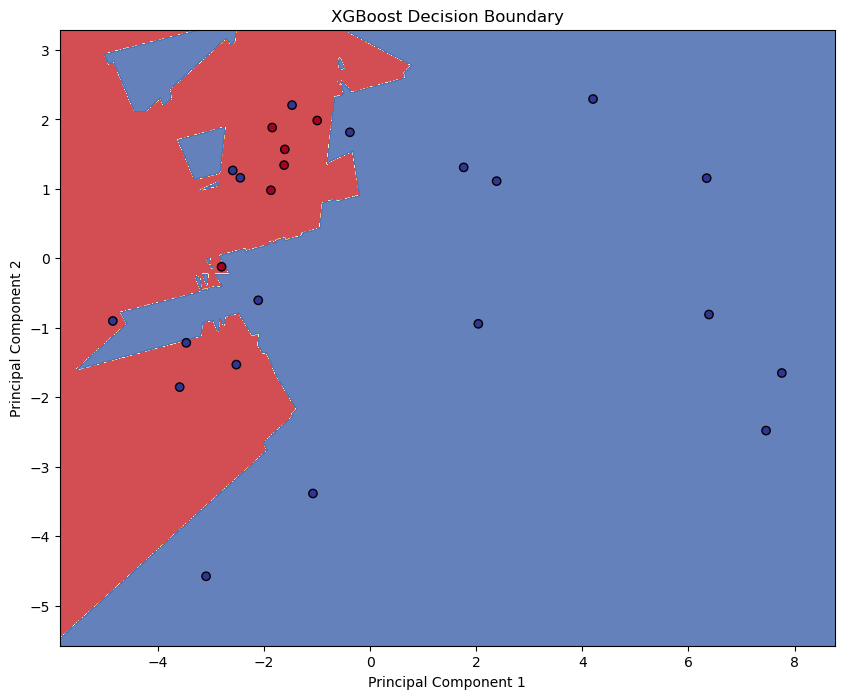

2025-02-06 10:59:56,083 - INFO - Generating feature importance plots for XGBoost...


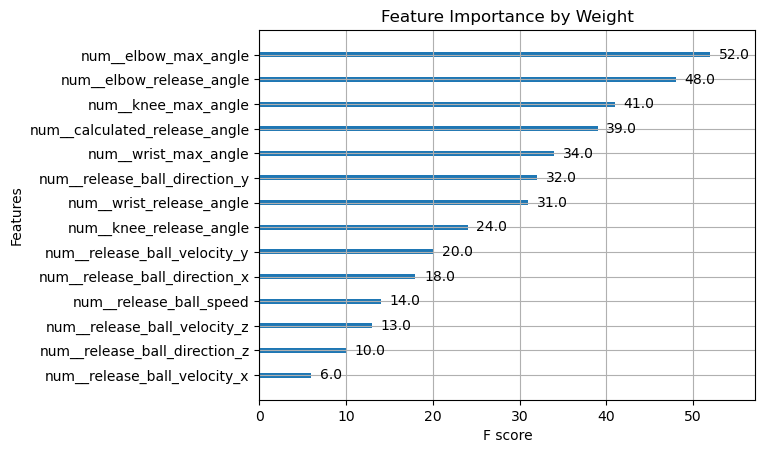

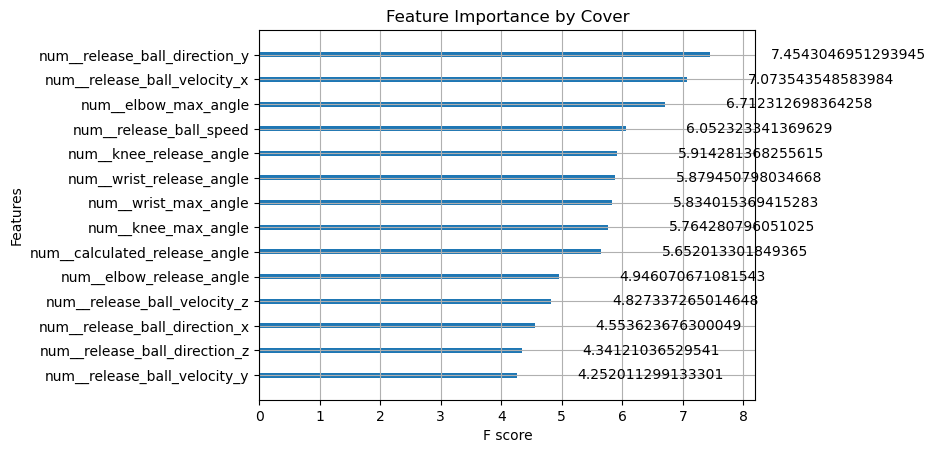

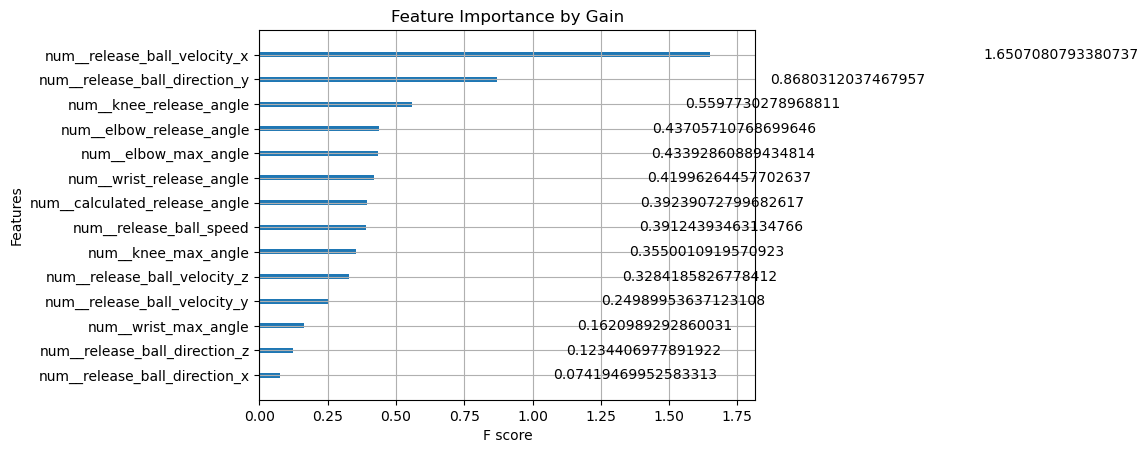

2025-02-06 10:59:56,462 - INFO - 📌 Tuning hyperparameters for Random Forest...
2025-02-06 10:59:56,463 - INFO - Starting hyperparameter tuning for Random Forest...
2025-02-06 10:59:56,467 - INFO - Parameter space: {'n_estimators': Integer(low=10, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None), 'bootstrap': Categorical(categories=(True, False), prior=None), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None)}
2025-02-06 11:00:58,415 - INFO - Best parameters found: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 50), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 10)])
2025-02-06 11:00:

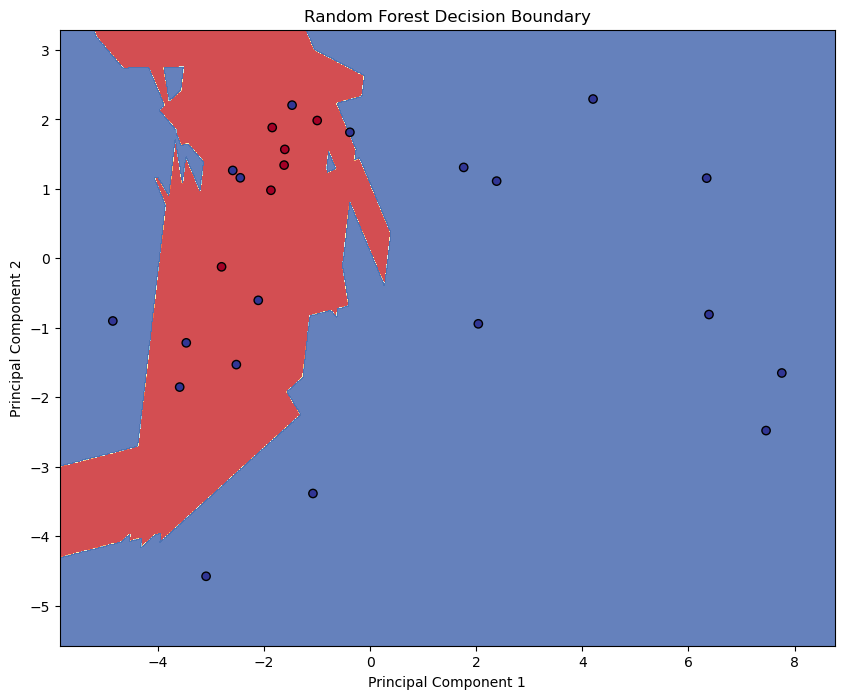

2025-02-06 11:00:58,818 - INFO - 📌 Tuning hyperparameters for Decision Tree...
2025-02-06 11:00:58,819 - INFO - Starting hyperparameter tuning for Decision Tree...
2025-02-06 11:00:58,822 - INFO - Parameter space: {'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None), 'splitter': Categorical(categories=('best', 'random'), prior=None)}
c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 1, 2, 'best'] before, using random point ['gini', 25, 7, 7, 'best']
  warnings.warn(
c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The 

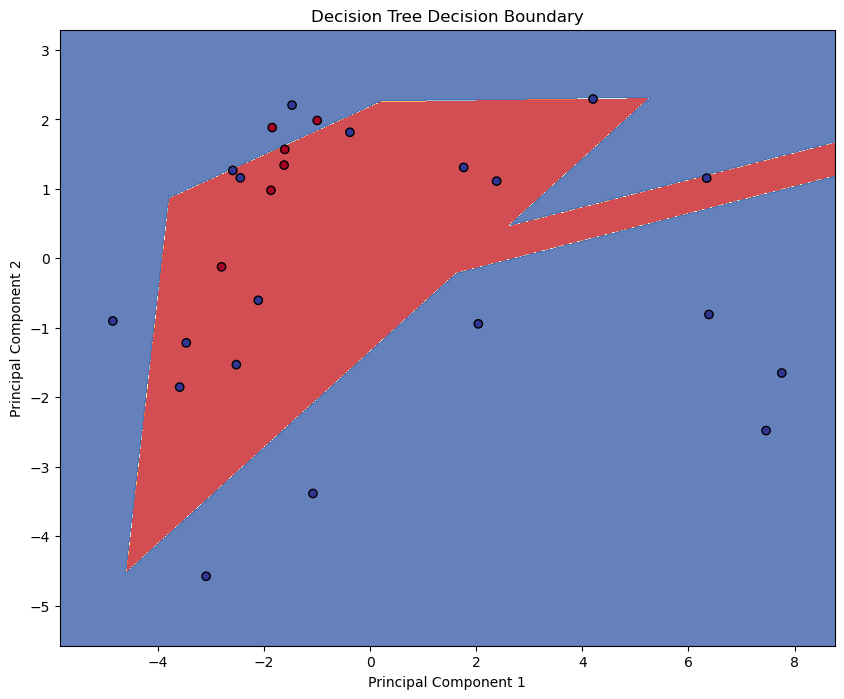

2025-02-06 11:01:30,440 - INFO - 📌 Tuning hyperparameters for CatBoost...
2025-02-06 11:01:30,441 - INFO - Starting hyperparameter tuning for CatBoost...
2025-02-06 11:01:30,443 - INFO - Parameter space for CatBoost: {'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='identity'), 'iterations': Integer(low=100, high=500, prior='uniform', transform='identity'), 'depth': Integer(low=3, high=10, prior='uniform', transform='identity'), 'l2_leaf_reg': Real(low=1, high=10, prior='uniform', transform='identity'), 'bagging_temperature': Real(low=0, high=1, prior='uniform', transform='identity'), 'border_count': Integer(low=32, high=255, prior='uniform', transform='identity')}
2025-02-06 11:03:14,170 - INFO - Best parameters found for CatBoost: OrderedDict([('bagging_temperature', 0.6886339372123115), ('border_count', 39), ('depth', 6), ('iterations', 199), ('l2_leaf_reg', 1.8685607895167105), ('learning_rate', 0.12123333562326334)])
2025-02-06 11:03:14,171 - INFO - Best c

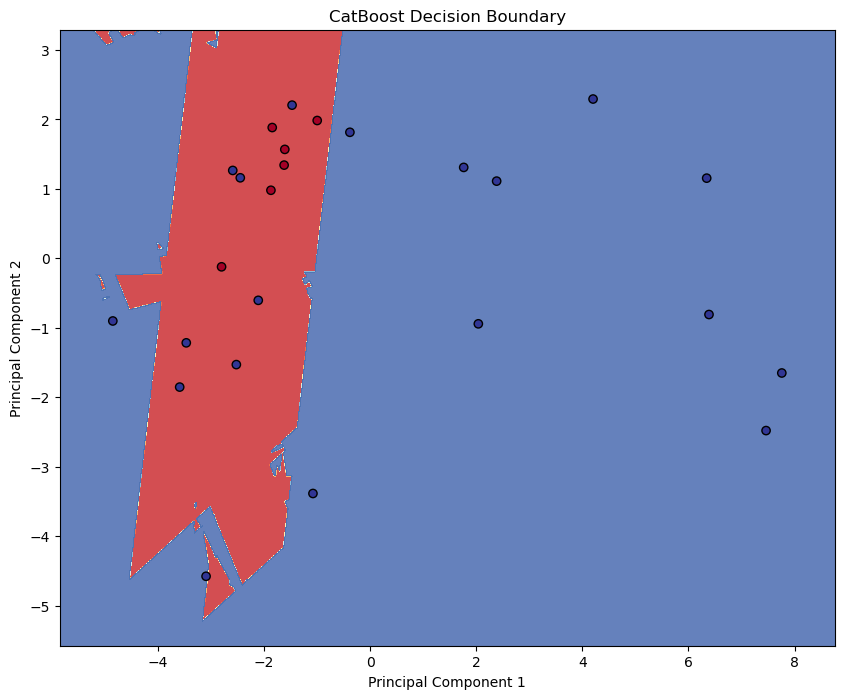

2025-02-06 11:03:17,106 - INFO - ✅ Best model is XGBoost with accuracy=0.72
2025-02-06 11:03:17,117 - INFO - Model saved to C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\model\XGBoost_model.pkl
2025-02-06 11:03:17,118 - INFO - ✅ Model 'XGBoost' saved successfully in 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\model'.
2025-02-06 11:03:17,120 - INFO - ✅ Tuning results saved to C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\model\tuning_results.json.
2025-02-06 11:03:17,121 - INFO - ✅ Training workflow completed successfully.


In [1]:
# %%writefile ml/train.py
import logging
from pathlib import Path
import pandas as pd
import os
import sys
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import json
from ml.config.config_loader import load_config  # New import for config
from ml.config.config_models import AppConfig
from datapreprocessor import DataPreprocessor
from ml.feature_selection.feature_importance_calculator import manage_features
from ml.train_utils.train_utils import (bayes_best_model_train
)

# Setup basic logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

print("WE'RE IN THIS DIRECTORY =", os.getcwd())
print("WE'RE IN THIS sys.path =", sys.path)

def main():
    # --- 1. Load Configuration via our new module ---
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    # load_config now returns an AppConfig instance (verified and typed)
    config: AppConfig = load_config(config_path)
    
    # --- 2. Use Config Values in the Code ---
    # Extract paths from configuration (using our typed model)
    paths_config = config.paths
    base_data_dir = Path(paths_config.data_dir).resolve()
    raw_data_file = base_data_dir / paths_config.raw_data

    # Output directories
    log_dir = Path(paths_config.log_dir).resolve()
    model_save_dir = Path(paths_config.model_save_base_dir).resolve()
    transformers_save_dir = Path(paths_config.transformers_save_base_dir).resolve()
    plots_output_dir = Path(paths_config.plots_output_dir).resolve()
    training_output_dir = Path(paths_config.training_output_dir).resolve()

    # Ensure output directories exist if needed
    model_save_dir.mkdir(parents=True, exist_ok=True)
    
    CLASSIFICATION_REPORT_PATH = model_save_dir / "classification_report.txt"
    TUNING_RESULTS_SAVE_PATH = model_save_dir / "tuning_results.json"

    # Extract model settings from the config
    selected_models = config.models.selected_models
    print(f"Selected Models: {selected_models}")
    selection_metric = config.models.selection_metric

    # Load the dataset
    try:
        filtered_df = pd.read_csv(raw_data_file)
        logger.info(f"✅ Loaded dataset from {raw_data_file}. Shape: {filtered_df.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        return
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    # Load feature metadata using manage_features
    feature_paths = {
        'features': '../../data/preprocessor/features_info/final_ml_df_selected_features_columns.pkl',
        'ordinal_categoricals': '../../data/preprocessor/features_info/ordinal_categoricals.pkl',
        'nominal_categoricals': '../../data/preprocessor/features_info/nominal_categoricals.pkl',
        'numericals': '../../data/preprocessor/features_info/numericals.pkl',
        'y_variable': '../../data/preprocessor/features_info/y_variable.pkl'
    }
    loaded = manage_features(mode='load', paths=feature_paths)
    if loaded:
        y_var = loaded.get('y_variable')
    else:
        logger.error("❌ Failed to load feature metadata.")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_var,
        ordinal_categoricals=loaded.get('ordinal_categoricals'),
        nominal_categoricals=loaded.get('nominal_categoricals'),
        numericals=loaded.get('numericals'),
        mode='train',
        debug=config.logging.debug,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=plots_output_dir,
        transformers_dir=transformers_save_dir
    )

    try:
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return

    # Proceed with training (tuning and model saving) using your existing function.
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=model_save_dir,
            classification_save_path=CLASSIFICATION_REPORT_PATH,
            tuning_results_save=TUNING_RESULTS_SAVE_PATH,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()


# Shap Functions for Prediction Module

### Prediction Module

In [3]:
# %%writefile ml/predict/predict.py

import pandas as pd
import logging
import os
import joblib
import json
from pathlib import Path
from typing import Any, Dict

# Local imports - Adjust based on your project structure
from ml.train_utils.train_utils import load_model  # Ensure correct import path
from datapreprocessor import DataPreprocessor  # Adjust as necessary

# Import new configuration loader
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig  # To use as type annotation

# Set up logger
logger = logging.getLogger("PredictAndAttachLogger")
logger.setLevel(logging.DEBUG)

# Set up console and file handlers
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
file_handler = logging.FileHandler("predictions.log")
file_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)
logger.addHandler(console_handler)
logger.addHandler(file_handler)

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def predict_and_attach_predict_probs(trained_model, X_preprocessed, X_inversed):
    # [Existing prediction code unchanged...]
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
        logger.debug(f"Predictions sample: {predictions[:5]}")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    try:
        prediction_probs = trained_model.predict_proba(X_preprocessed)
        logger.info("✅ Prediction probabilities computed successfully.")
        logger.debug(f"Prediction probabilities sample:\n{prediction_probs[:2]}")
    except Exception as e:
        logger.error(f"❌ Prediction probabilities computation failed: {e}")
        return

    if hasattr(trained_model, 'classes_'):
        class_labels = trained_model.classes_
    else:
        class_labels = [f'class_{i}' for i in range(prediction_probs.shape[1])]

    try:
        if X_inversed is not None:
            if 'Prediction' not in X_inversed.columns:
                X_inversed['Prediction'] = predictions
                logger.debug("Predictions attached to inverse-transformed DataFrame.")
            if 'Prediction_Probabilities' not in X_inversed.columns:
                X_inversed['Prediction_Probabilities'] = prediction_probs.tolist()
                logger.debug("Prediction probabilities attached to inverse-transformed DataFrame.")
            for idx, label in enumerate(class_labels):
                col_name = f'Probability_{label}'
                X_inversed[col_name] = prediction_probs[:, idx]
                logger.debug(f"Attached column: {col_name}")
            X_inversed.drop(columns=['Prediction_Probabilities'], inplace=True)
            logger.debug(f"Final shape of X_inversed: {X_inversed.shape}")
            logger.debug(f"Final columns in X_inversed: {X_inversed.columns.tolist()}")
        else:
            logger.warning("X_inversed is None. Creating a new DataFrame with predictions.")
            data = {'Prediction': predictions, 'Prediction_Probabilities': prediction_probs.tolist()}
            for idx, label in enumerate(class_labels):
                col_name = f'Probability_{label}'
                data[col_name] = prediction_probs[:, idx]
            X_inversed = pd.DataFrame(data)
            X_inversed.drop(columns=['Prediction_Probabilities'], inplace=True)
            logger.debug(f"Created new X_inversed DataFrame with shape: {X_inversed.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to attach predictions to inverse-transformed DataFrame: {e}")
        X_inversed = pd.DataFrame({'Prediction': predictions})
        return

    return predictions, prediction_probs, X_inversed

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    data_dir = Path(config.paths.data_dir).resolve()
    raw_data_path = data_dir / config.paths.raw_data
    processed_data_dir = data_dir / config.paths.processed_data_dir
    transformers_dir = Path(config.paths.transformers_save_base_dir).resolve()
    predictions_output_dir = Path(config.paths.predictions_output_dir).resolve()
    log_dir = Path(config.paths.log_dir).resolve()
    model_save_dir = Path(config.paths.model_save_base_dir).resolve()
    log_file = config.paths.log_file

    logger.info("✅ Starting prediction module.")

    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.features
    column_assets = {
        'y_variable': features_config.y_variable,
        'ordinal_categoricals': features_config.ordinal_categoricals,
        'nominal_categoricals': features_config.nominal_categoricals,
        'numericals': features_config.numericals
    }

    # ----------------------------
    # Step 4: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 5: Load the Prediction Dataset
    # ----------------------------
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = pd.read_csv(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # ----------------------------
    # Step 6: Initialize DataPreprocessor
    # ----------------------------
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Adjust if needed based on best_model_name
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},
        debug=False,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )

    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type =", type(X_preprocessed), "X_new_inverse type =", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        model_path = model_save_dir / best_model_name.replace(" ", "_") / 'trained_model.pkl'
        logger.info(f"✅ Trained model loaded from '{model_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions and Attach Probabilities
    # ----------------------------
    predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(trained_model, X_preprocessed, X_inversed)
    print(X_inversed)

    # ----------------------------
    # Step 9: Save Predictions
    # ----------------------------
    try:
        predictions_output_dir.mkdir(parents=True, exist_ok=True)
        predictions_filename = predictions_output_dir / f'predictions_{best_model_name.replace(" ", "_")}.csv'
        X_inversed.to_csv(predictions_filename, index=False)
        logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    logger.info(f"✅ All prediction tasks completed successfully for model '{best_model_name}'.")

if __name__ == "__main__":
    main()


2025-02-02 15:45:47,015 - PredictAndAttachLogger - INFO - ✅ Starting prediction module.
2025-02-02 15:45:47,015 - INFO - ✅ Starting prediction module.
2025-02-02 15:45:47,021 - PredictAndAttachLogger - INFO - Best model identified: XGBoost
2025-02-02 15:45:47,021 - INFO - Best model identified: XGBoost
2025-02-02 15:45:47,028 - PredictAndAttachLogger - INFO - ✅ Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\..\..\data\processed\final_ml_dataset.csv'.
2025-02-02 15:45:47,028 - INFO - ✅ Prediction input data loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\..\..\data\processed\final_ml_dataset.csv'.
2025-02-02 15:45:47,029 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-02 15:45:47,029 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-02 15:45:47,029 [INFO] St

[Config Loader] ✅ Successfully loaded configuration from ..\..\data\model\preprocessor_config\preprocessor_config.yaml
X_new_preprocessed type = <class 'pandas.core.frame.DataFrame'> X_new_inverse type = <class 'pandas.core.frame.DataFrame'>
     release_ball_direction_x  release_ball_direction_z  \
0                    0.377012                  0.926203   
1                    0.417644                  0.901906   
2                    0.383086                  0.922353   
3                    0.292054                  0.956396   
4                    0.389917                  0.918894   
..                        ...                       ...   
120                  0.460703                  0.886986   
121                  0.411186                  0.911511   
122                  0.161727                  0.986537   
123                  0.114865                  0.966452   
124                  0.266885                  0.962290   

     release_ball_direction_y  elbow_release_angl

In [5]:
%%writefile ml/shap/shap_utils.py

import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from pathlib import Path
from typing import Any, Dict, List, Optional
# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


def compute_shap_values(model, X, debug: bool = False, logger: logging.Logger = None):
    if logger:
        logger.info("Initializing SHAP explainer...")

    try:
        explainer = shap.Explainer(model, X)
        if logger and debug:
            logger.debug(f"SHAP Explainer initialized: {type(explainer)}")
            logger.debug(f"Explainer details: {explainer}")

        shap_values = explainer(X)
        if logger and debug:
            logger.debug(f"SHAP values computed: {type(shap_values)}")
            logger.debug(f"Shape of shap_values: {shap_values.shape}")
            if hasattr(shap_values, 'values'):
                logger.debug(f"Sample SHAP values:\n{shap_values.values[:2]}")
            if hasattr(shap_values, 'feature_names'):
                logger.debug(f"SHAP feature names: {shap_values.feature_names}")

        # Determine number of classes
        n_classes = len(model.classes_)
        logger.debug(f"Number of classes in the model: {n_classes}")

        if shap_values.values.ndim == 3:
            if n_classes > 1:
                # For multi-class classification, select SHAP values for the positive class
                shap_values_class = shap_values.values[:, :, 1]
                logger.debug(f"Extracted SHAP values for class 1: Shape {shap_values_class.shape}")
            else:
                # For single-class models, retain SHAP values as is
                shap_values_class = shap_values.values[:, :, 0]
                logger.debug(f"Extracted SHAP values for single class: Shape {shap_values_class.shape}")
        elif shap_values.values.ndim == 2:
            if n_classes > 1:
                # For binary classification, SHAP returns 2D array for the positive class
                shap_values_class = shap_values.values
                logger.debug(f"Extracted SHAP values for positive class: Shape {shap_values_class.shape}")
            else:
                shap_values_class = shap_values.values
                logger.debug(f"Extracted SHAP values for single class: Shape {shap_values_class.shape}")
        else:
            logger.error(f"Unexpected SHAP values dimensions: {shap_values.values.ndim}")
            raise ValueError("Unexpected SHAP values dimensions.")

        return explainer, shap_values_class
    except Exception as e:
        if logger:
            logger.error(f"Failed to compute SHAP values: {e}")
        raise


def plot_shap_summary(shap_values, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                     logger: logging.Logger = None):
    """
    Generate and save a SHAP summary plot.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (preprocessed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info("Generating SHAP summary plot...")
        logger.debug(f"Type of shap_values: {type(shap_values)}")
        logger.debug(f"Shape of shap_values: {shap_values.shape}")
        
        # Check if shap_values is a shap.Explanation object
        if isinstance(shap_values, shap.Explanation):
            logger.debug(f"SHAP feature names: {shap_values.feature_names}")
        else:
            logger.debug("shap_values is not a shap.Explanation object. Attempting to extract feature names.")
            if hasattr(shap_values, 'feature_names'):
                logger.debug(f"shap_values feature names: {shap_values.feature_names}")
            else:
                logger.debug("Cannot extract feature names from shap_values.")
        
        logger.debug(f"Type of X_original: {type(X_original)}")
        logger.debug(f"Shape of X_original: {X_original.shape}")
        logger.debug(f"Columns in X_original: {X_original.columns.tolist()}")
        
        # Verify column alignment
        if isinstance(shap_values, shap.Explanation):
            shap_feature_names = shap_values.feature_names
        elif hasattr(shap_values, 'feature_names'):
            shap_feature_names = shap_values.feature_names
        else:
            shap_feature_names = X_original.columns.tolist()  # Fallback
        
        if list(shap_feature_names) != list(X_original.columns):
            logger.error("Column mismatch between SHAP values and X_original.")
            logger.error(f"SHAP feature names ({len(shap_feature_names)}): {shap_feature_names}")
            logger.error(f"X_original columns ({len(X_original.columns)}): {X_original.columns.tolist()}")
            raise ValueError("Column mismatch between SHAP values and X_original.")
        else:
            logger.debug("Column alignment verified between SHAP values and X_original.")
    
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP summary plot saved to {save_path}")
        if logger:
            logger.info("SHAP summary plot generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP summary plot: {e}")
        raise




def plot_shap_dependence(shap_values, feature: str, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                         logger: logging.Logger = None):
    """
    Generate and save a SHAP dependence plot for a specific feature.

    :param shap_values: SHAP values computed for the dataset.
    :param feature: Feature name to generate the dependence plot for.
    :param X_original: Original (untransformed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info(f"Generating SHAP dependence plot for feature '{feature}'...")
    try:
        plt.figure(figsize=(8, 6))
        # shap.dependence_plot(feature, shap_values.values, X_original, show=False)
        shap.dependence_plot(feature, shap_values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP dependence plot for '{feature}' saved to {save_path}")
        if logger:
            logger.info(f"SHAP dependence plot for feature '{feature}' generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP dependence plot for feature '{feature}': {e}")
        raise


def generate_global_recommendations(shap_values, X_original: pd.DataFrame, top_n: int = 5, debug: bool = False, 
                                    use_mad: bool = False, logger: logging.Logger = None) -> dict:
    """
    Generate global recommendations based on SHAP values and feature distributions.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (untransformed) feature DataFrame.
    :param top_n: Number of top features to generate recommendations for.
    :param debug: If True, enable detailed debug logs.
    :param use_mad: If True, use Median Absolute Deviation for range definition.
    :param logger: Logger instance for logging.
    :return: recommendations: Dictionary mapping features to recommended value ranges, importance, and direction.
    """
    if logger:
        logger.info("Generating feature importance based on SHAP values...")
    try:
        # shap_df = pd.DataFrame(shap_values.values, columns=X_original.columns)
        shap_df = pd.DataFrame(shap_values, columns=X_original.columns)

        # Calculate mean absolute SHAP values for importance
        feature_importance = pd.DataFrame({
            'feature': X_original.columns,
            'importance': np.abs(shap_df).mean(axis=0),
            'mean_shap': shap_df.mean(axis=0)
        }).sort_values(by='importance', ascending=False)
        
        if logger and debug:
            logger.debug(f"Feature importance (top {top_n}):\n{feature_importance.head(top_n)}")
        
        top_features = feature_importance.head(top_n)['feature'].tolist()
        recommendations = {}
        
        for feature in top_features:
            feature_values = X_original[feature]
            
            if use_mad:
                # Use Median and MAD for robust statistics
                median = feature_values.median()
                mad = feature_values.mad()
                lower_bound = median - 1.5 * mad
                upper_bound = median + 1.5 * mad
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            else:
                # Default to Interquartile Range (IQR)
                lower_bound = feature_values.quantile(0.25)
                upper_bound = feature_values.quantile(0.75)
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            
            # Determine direction based on mean SHAP value
            mean_shap = feature_importance.loc[feature_importance['feature'] == feature, 'mean_shap'].values[0]
            direction = 'positive' if mean_shap > 0 else 'negative'
            
            recommendations[feature] = {
                'range': range_str,
                'importance': round(feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0], 4),  # Rounded for readability
                'direction': direction
            }
            if logger and debug:
                logger.debug(f"Recommendation for {feature}: Range={range_str}, Importance={feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0]}, Direction={direction}")
        
        if logger and debug:
            logger.debug(f"Final Recommendations with Importance and Direction: {recommendations}")
        return recommendations
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate global recommendations: {e}")
        raise


def generate_individual_feedback(trial: pd.Series, shap_values_trial: np.ndarray,
                                 feature_metadata: dict = None, logger: logging.Logger = None) -> dict:
    """
    Generate individual feedback for a single trial and break it out into several pieces for each feature.
    
    For each feature, three keys will be generated:
      1. shap_{sign}_direction_{feature}: A recommendation such as "decrease" or "maintain or increase"
      2. shap_importance_{feature}: The absolute SHAP value (rounded) for that feature in this trial
      3. shap_{sign}_unit_change_{feature}: The computed unit–change (with unit) for that feature.
    
    :param trial: A pandas Series containing the trial's feature values.
    :param shap_values_trial: A numpy array with the SHAP values for the trial.
    :param feature_metadata: A dictionary with metadata per feature (e.g. units).
    :param logger: Optional logger for debugging.
    :return: A dictionary containing the feedback.
    """
    feedback = {}
    
    # Loop over each feature and its associated SHAP value.
    for feature, shap_val in zip(trial.index.tolist(), shap_values_trial):
        # Choose the sign and suggestion based on the SHAP value.
        if shap_val > 0:
            sign = "positive"
            suggestion = "increase"
        elif shap_val < 0:
            sign = "negative"
            suggestion = "decrease"
        else:
            # If SHAP is zero, mark it as no impact.
            feedback[f"shap_{feature}_impact"] = "no impact"
            continue

        # Compute the adjustment amount as (e.g.) 10% of the current value's absolute.
        current_value = trial[feature]
        adjustment_factor = 0.1
        unit_change_value = adjustment_factor * abs(current_value)
        
        # Retrieve unit from feature_metadata, if available.
        unit = ""
        if feature_metadata and feature in feature_metadata:
            unit = feature_metadata[feature].get('unit', '')
        # Format the unit change as a string.
        unit_change_str = f"{unit_change_value:.2f} {unit}".strip()

        # The importance for the feature in this trial is simply the absolute value of the SHAP value.
        importance = abs(shap_val)
        
        # Create key names.
        key_direction = f"shap_direction_{feature}"
        key_importance = f"shap_importance_{feature}"
        key_unit_change = f"shap_unit_change_{feature}"
        
        # Set values.
        feedback[key_direction] = suggestion
        feedback[key_importance] = round(importance, 4)
        feedback[key_unit_change] = unit_change_str

        if logger and logger.isEnabledFor(logging.DEBUG):
            logger.debug(f"For feature '{feature}': {key_direction}='{suggestion}', "
                         f"{key_importance}={round(importance, 4)}, {key_unit_change}='{unit_change_str}'")
    return feedback



def expand_specific_feedback(df: pd.DataFrame, logger: Optional[logging.Logger] = None) -> pd.DataFrame:
    """
    Expand the 'specific_feedback' column from dictionaries to separate columns.

    :param df: Original DataFrame containing the 'specific_feedback' column.
    :param logger: Optional logger for debugging.
    :return: Expanded DataFrame with separate feedback columns.
    """
    if 'specific_feedback' not in df.columns:
        logger.error("'specific_feedback' column not found in DataFrame.")
        raise KeyError("'specific_feedback' column not found.")
    
    logger.info("Expanding 'specific_feedback' into separate columns.")
    try:
        feedback_df = df['specific_feedback'].apply(pd.Series)
        logger.debug(f"Feedback DataFrame shape after expansion: {feedback_df.shape}")
        
        # Optional: Handle missing values
        feedback_df.fillna('No feedback available', inplace=True)
        
        # Merge with original DataFrame
        df_expanded = pd.concat([df.drop(columns=['specific_feedback']), feedback_df], axis=1)
        logger.info("'specific_feedback' expanded successfully.")
        return df_expanded
    except Exception as e:
        logger.error(f"Failed to expand 'specific_feedback': {e}")
        raise




def compute_individual_shap_values(explainer, X_transformed: pd.DataFrame, trial_index: int, 
                                   logger: logging.Logger = None):
    """
    Compute SHAP values for a single trial.

    :param explainer: SHAP explainer object.
    :param X_transformed: Transformed features used for prediction.
    :param trial_index: Index of the trial.
    :param logger: Logger instance.
    :return: shap_values for the trial.
    """
    if logger:
        logger.info(f"Computing SHAP values for trial at index {trial_index}...")
    try:
        trial = X_transformed.iloc[[trial_index]]
        shap_values = explainer(trial)
        if logger:
            logger.debug(f"SHAP values for trial {trial_index} computed successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to compute SHAP values for trial {trial_index}: {e}")
        raise
    return shap_values


def plot_individual_shap_force(shap_explainer, shap_values, X_original: pd.DataFrame, trial_index: int, 
                               save_path: str, logger: logging.Logger = None):
    """
    Generate and save a SHAP force plot for a specific trial.

    :param shap_explainer: SHAP explainer object.
    :param shap_values: SHAP values for the trial.
    :param X_original: Original feature DataFrame.
    :param trial_index: Index of the trial.
    :param save_path: Full file path to save the force plot.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Generating SHAP force plot for trial {trial_index}...")
    try:
        shap_plot = shap.force_plot(
            shap_explainer.expected_value, 
            shap_values.values[0], 
            X_original.iloc[trial_index],
            matplotlib=False
        )
        shap.save_html(save_path, shap_plot)
        if logger:
            logger.debug(f"SHAP force plot saved to {save_path}")
            logger.info(f"SHAP force plot for trial {trial_index} generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP force plot for trial {trial_index}: {e}")
        raise


def extract_force_plot_values(shap_values, trial_index: int, logger: logging.Logger = None) -> dict:
    """
    Extract SHAP values and feature contributions for a specific trial.

    Args:
        shap_values (shap.Explanation): SHAP values object.
        trial_index (int): Index of the trial.
        logger (logging.Logger, optional): Logger instance.

    Returns:
        dict: Dictionary of feature contributions.
    """
    try:
        shap_values_instance = shap_values.values[trial_index]
        features_instance = shap_values.data[trial_index]
        feature_contributions = dict(zip(shap_values.feature_names, shap_values_instance))
        if logger and logger.isEnabledFor(logging.DEBUG):
            logger.debug(f"SHAP values for trial {trial_index}: {feature_contributions}")
        return feature_contributions
    except Exception as e:
        if logger:
            logger.error(f"Error extracting SHAP values for trial {trial_index}: {e}")
        raise


def save_shap_values(shap_values, save_path: str, logger: logging.Logger = None):
    """
    Save SHAP values to a file using pickle.

    :param shap_values: SHAP values object to save.
    :param save_path: File path to save the SHAP values.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Saving SHAP values to {save_path}...")
    try:
        with open(save_path, "wb") as f:
            pickle.dump(shap_values, f)
        if logger:
            logger.info(f"SHAP values saved successfully to {save_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to save SHAP values: {e}")
        raise


def load_shap_values(load_path: str, logger: logging.Logger = None):
    """
    Load SHAP values from a pickle file.

    :param load_path: File path to load the SHAP values from.
    :param logger: Logger instance.
    :return: Loaded SHAP values object.
    """
    if logger:
        logger.info(f"Loading SHAP values from {load_path}...")
    try:
        with open(load_path, "rb") as f:
            shap_values = pickle.load(f)
        if logger:
            logger.info(f"SHAP values loaded successfully from {load_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load SHAP values: {e}")
        raise
    return shap_values

def get_shap_row(shap_values, df: pd.DataFrame, trial_id: Any, logger: Optional[logging.Logger] = None):
    """
    Retrieve the SHAP values by converting a string-based trial ID
    to its integer position (row index) in the DataFrame.

    :param shap_values: The array-like SHAP values (often shap.Explanation or np.ndarray).
    :param df: A pandas DataFrame indexed by trial IDs.
    :param trial_id: The ID (string or other) we want to map to a row position.
    :param logger: Optional logger for debug or warning messages.
    :return: The 1D array of SHAP values for the specified row, or None if not found.
    """
    if trial_id not in df.index:
        if logger:
            logger.warning(f"Trial ID '{trial_id}' not found in df.index: {df.index.tolist()}")
        return None

    # Convert the string-based index (e.g., "T0123") to its integer position
    pos = df.index.get_loc(trial_id)
    if logger and logger.isEnabledFor(logging.DEBUG):
        logger.debug(f"Mapped trial ID '{trial_id}' to position {pos} in the DataFrame.")

    return shap_values[pos]


def plot_shap_force(shap_explainer, shap_values, X_original, trial_index, 
                    save_path: Path, debug: bool = False, logger: Optional[logging.Logger] = None):
    try:
        # Retrieve the correct SHAP row and trial features
        if isinstance(trial_index, int):
            shap_value = shap_values[trial_index]
            trial_features = X_original.iloc[[trial_index]]  # Pass as DataFrame (1-row)
            if logger and debug:
                logger.debug(f"Using integer index {trial_index} for force plot.")
        else:
            shap_value = get_shap_row(shap_values, X_original, trial_index, logger=logger)
            if shap_value is None:
                if logger:
                    logger.warning(f"SHAP row not found for trial '{trial_index}'.")
                return
            trial_features = X_original.loc[[trial_index]]  # keep as DataFrame

        # Determine the expected value and ensure it is a scalar (or select the first element if iterable)
        if hasattr(shap_explainer.expected_value, '__iter__'):
            base_value = shap_explainer.expected_value[0]
            if logger and debug:
                logger.debug(f"Expected value is iterable; using {base_value}.")
        else:
            base_value = shap_explainer.expected_value
            if logger and debug:
                logger.debug(f"Expected value is scalar: {base_value}")

        # **Key change:** Use matplotlib=False so that the returned object is an interactive Visualizer
        shap_plot = shap.force_plot(
            base_value, 
            shap_value, 
            trial_features,
            matplotlib=False  # Ensures an interactive (HTML/JS) plot is returned
        )
        
        # Save the interactive plot as an HTML file.
        # (It’s a best practice to convert save_path to string)
        shap.save_html(str(save_path), shap_plot)
        if logger and debug:
            logger.debug(f"Interactive SHAP force plot saved to {save_path}.")
        if logger:
            logger.info(f"✅ Interactive SHAP force plot generated for trial {trial_index}.")
    
    except Exception as e:
        if logger:
            logger.error(f"❌ Failed to generate SHAP force plot for trial {trial_index}: {e}")
        raise


# Below is an updated version of shap_utils.py that includes additional functionality.
# This functionality helps compute a percentile-based error limit (unit_change_error_limit)
# for each feature (metric), then uses that limit alongside the computed shap_unit_change_{metric}
# and shap_direction_{metric} to determine a trial-based feedback label such as "early", "good",
# or "late".
#
# The new function introduced at the end is `compute_feedback_with_thresholds`. Inside it, we:
# 1) Collect a data distribution for each metric from the entire dataset (or a relevant subset).
# 2) Compute a chosen percentile (like the 90th percentile) for each metric to determine an error limit.
# 3) Retrieve shap_unit_change_{metric} and shap_direction_{metric} from the feedback.
#    - If "increase" -> the "goal" is current_value + shap_unit_change.
#    - If "decrease" -> the "goal" is current_value - shap_unit_change.
# 4) Compare the difference (or ratio) between the goal and the actual distribution of that metric to see
#    if the difference is within or beyond the error limit.
# 5) Mark trial-based feedback as "early", "good", or "late" accordingly.
#
# NOTE: This is sample logic and can be adapted to match your exact domain definitions.
#       Additional logging or debugging can be added as needed.

import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from pathlib import Path
from typing import Any, Dict, List, Optional

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Other functions omitted for brevity...

###########################################
# NEW FUNCTION: compute_feedback_with_thresholds
###########################################

def compute_feedback_with_thresholds(
    df: pd.DataFrame,
    features: List[str],
    percentile: float = 90,
    logger: Optional[logging.Logger] = None
) -> pd.DataFrame:
    """
    This function demonstrates how to add percentile-based thresholds for each metric.

    Steps:
    1) For each metric in 'features', calculate the chosen percentile (e.g. 90th) across all trials.
       This is our 'unit_change_error_limit' for that metric.
    2) We look for the shap_direction_{metric} and shap_unit_change_{metric} columns in df.
       If they say "increase" or "decrease", we can compute the 'goal' metric as:
         - If direction is 'increase':  goal = actual_value + shap_unit_change (numerical interpretation)
         - If direction is 'decrease':  goal = actual_value - shap_unit_change
    3) Compare the difference between this 'goal' and the actual_value to see if it is within
       the 'unit_change_error_limit'. Then assign feedback: 'early', 'good', or 'late'.
       (The user can define the exact rules for these categories. We'll show an example.)

    Returns:
       The same DataFrame 'df', but with new columns:
         - {feature}_threshold
         - shap_feedback_{feature}
       which store the threshold used and the final feedback label.
    """
    df_out = df.copy()

    # 1) Compute the percentile for each feature across the dataset.
    thresholds = {}
    for metric in features:
        if metric not in df_out.columns:
            if logger:
                logger.warning(f"Metric '{metric}' not found in df columns, skipping.")
            continue
        threshold_value = np.percentile(df_out[metric].dropna(), percentile)
        thresholds[metric] = threshold_value
        if logger:
            logger.info(f"{percentile}th percentile for '{metric}' is {threshold_value:.3f}.")

    # 2) For each metric, retrieve direction & unit_change columns if they exist.
    for metric in features:
        dir_col = f"shap_direction_{metric}"
        uc_col = f"shap_unit_change_{metric}"

        threshold_col = f"{metric}_threshold"
        feedback_col = f"shap_feedback_{metric}"

        # We'll store the threshold for reference.
        if metric in thresholds:
            df_out[threshold_col] = thresholds[metric]
        else:
            df_out[threshold_col] = np.nan

        # If direction or unit change columns are absent, skip.
        if dir_col not in df_out.columns or uc_col not in df_out.columns:
            if logger:
                logger.debug(f"Either {dir_col} or {uc_col} not found in df columns. Skipping feedback.")
            df_out[feedback_col] = "No feedback"
            continue

        # We'll parse the numeric portion from shap_unit_change_{metric} because that might be something like '0.45 meters'.
        # Let's define a helper to parse the numeric part.
        def parse_value_with_unit(value_str: Any) -> float:
            if isinstance(value_str, (int, float)):
                return float(value_str)
            try:
                # example: "0.45 meters", split by space, parse first item
                parts = str(value_str).split()
                return float(parts[0])
            except:
                return 0.0

        # Now define an inline function to compute feedback row by row.
        def compute_row_feedback(row):
            # If we have no actual metric col in the row, skip.
            if pd.isnull(row.get(metric, np.nan)):
                return "No actual metric"

            actual_val = row[metric]
            direction = row[dir_col]
            # shap_unit_change_{metric} might be numeric or str with unit, parse.
            shap_delta = parse_value_with_unit(row[uc_col])

            # compute "goal"
            if direction == "increase":
                goal_val = actual_val + shap_delta
            elif direction == "decrease":
                goal_val = actual_val - shap_delta
            else:
                # e.g. 'no feedback available' or something else.
                return "No direction"

            # difference from goal
            diff = abs(goal_val - actual_val)

            # compare with threshold
            limit = thresholds.get(metric, np.nan)
            if pd.isnull(limit) or limit == 0:
                # fallback if threshold not found.
                return "No threshold"

            # Define rules based on percentiles:
            if diff <= 0.05 * limit:
                return "good"
            elif diff > 0.05 * limit and goal_val > actual_val:
                return "early"
            elif diff > 0.05 * limit and goal_val < actual_val:
                return "late"
            else:
                return "No feedback"

        df_out[feedback_col] = df_out.apply(compute_row_feedback, axis=1)

    return df_out


Overwriting ml/shap/shap_utils.py


In [1]:
# %%writefile ml/predict_with_shap_usage.py
import pandas as pd
import logging
import os
import json
from pathlib import Path
from typing import Any, Dict, List, Optional
from datetime import datetime
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import pickle
import logging.config
import ast

# Import configuration loader and models
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig
# Import other necessary modules
from ml.train_utils.train_utils import load_model
from ml.feature_selection.feature_importance_calculator import manage_features

# Optionally, import SHAP helpers if needed:
# Local imports for SHAP and model loading should be uncommented and adjusted as needed
from ml.shap.shap_utils import (
    compute_shap_values,
    plot_shap_summary,
    plot_shap_dependence,
    generate_global_recommendations,
    generate_individual_feedback,
    plot_shap_force,
    expand_specific_feedback
)

# Assume these are imported in the modules that call them
from datapreprocessor import DataPreprocessor
from ml.predict.predict import predict_and_attach_predict_probs


def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)


def setup_logging(config: AppConfig, log_file_path: Path) -> logging.Logger:
    log_level = config.logging.level.upper()
    # Option 1: Remove file handler entirely (for ease)
    logging_config = {
        'version': 1,
        'disable_existing_loggers': False,
        'formatters': {
            'standard': {
                'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            },
        },
        'handlers': {
            'console': {
                'class': 'logging.StreamHandler',
                'level': log_level,
                'formatter': 'standard',
                'stream': 'ext://sys.stdout',
            },
        },
        'loggers': {
            '__main__': {
                'handlers': ['console'],
                'level': log_level,
                'propagate': False
            },
        }
    }
    logging.config.dictConfig(logging_config)
    return logging.getLogger(__name__)


def unpack_feedback(feedback: any) -> None:
    if feedback is None:
        print("No feedback available.")
        return

    if isinstance(feedback, dict):
        feedback_dict = feedback
    elif isinstance(feedback, str):
        try:
            # Print raw feedback for debugging
            print("Raw feedback string (repr):", repr(feedback))
            feedback_dict = ast.literal_eval(feedback)
        except Exception as e:
            print(f"ast.literal_eval failed: {e}")
            return
    else:
        print("Feedback is not in a recognized format.")
        return

    print("Trial Specific Feedback:")
    for metric, suggestion in feedback_dict.items():
        print(f"  {metric}: {suggestion}")


def predict_and_shap(
      config: AppConfig,
      df_input: pd.DataFrame,
      save_dir: Path,
      generate_summary_plot: bool = True,
      generate_dependence_plots: bool = False,
      generate_force_plots_or_feedback_indices: Optional[List[Any]] = None,
      top_n_features: int = 10,
      use_mad: bool = False,
      generate_feedback: bool = False,
      index_column: Optional[str] = None,
      logger: Optional[logging.Logger] = None,
      # Optional overrides for feature file paths:
      features_file: Optional[Path] = None,
      ordinal_file: Optional[Path] = None,
      nominal_file: Optional[Path] = None,
      numericals_file: Optional[Path] = None,
      y_variable_file: Optional[Path] = None,
      model_save_dir_override: Optional[Path] = None,
      transformers_dir_override: Optional[Path] = None
) -> Dict[str, Any]:
    results = {}
    # Use dot‑notation to access configuration values
    data_dir = Path(config.paths.data_dir).resolve()
    model_save_dir = Path(config.paths.model_save_base_dir).resolve() if model_save_dir_override is None else model_save_dir_override.resolve()
    transformers_dir = Path(config.paths.transformers_save_base_dir).resolve() if transformers_dir_override is None else transformers_dir_override.resolve()
    # Use the configuration for feature paths:
    features_file = Path(config.paths.features_metadata_file) if features_file is None else features_file
    # [Set other feature file defaults similarly]

    # Load tuning results, select best model, etc.
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        raise FileNotFoundError(f"Tuning results not found at '{tuning_results_path}'.")
    with open(tuning_results_path, 'r') as f:
        tuning_results = json.load(f)
    best_model_info = tuning_results.get("Best Model")
    if not best_model_info:
        raise ValueError("Best model information not found in tuning results.")
    best_model_name = best_model_info.get("model_name")
    if not best_model_name:
        raise ValueError("Best model name not found in tuning results.")
    if logger:
        logger.info(f"Best model identified: {best_model_name}")
    model_path = model_save_dir / best_model_name.replace(' ', '_') / "trained_model.pkl"

    # Load feature lists (via manage_features) and initialize DataPreprocessor
    # Build the feature paths dictionary:
    feature_paths = {
        'features': features_file,
        'ordinal_categoricals': ordinal_file,
        'nominal_categoricals': nominal_file,
        'numericals': numericals_file,
        'y_variable': y_variable_file
    }
    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
        if logger:
            logger.debug(f"Loaded Feature Lists: y_variable={y_variable_list}, ordinal_categoricals={ordinal_categoricals}, nominal_categoricals={nominal_categoricals}, numericals={numericals}")
    except Exception as e:
        if logger:
            logger.warning(f"Feature lists could not be loaded: {e}")
        y_variable_list, ordinal_categoricals, nominal_categoricals, numericals = [], [], [], []

    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )
    
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_input)
        if logger:
            logger.info("Preprocessing completed successfully in predict mode.")
    except Exception as e:
        if logger:
            logger.error(f"Preprocessing failed: {e}")
        raise

    duplicates = X_inversed.index.duplicated()
    if duplicates.any():
        print("Duplicate trial IDs found:", X_inversed.index[duplicates].tolist())
    else:
        print("Trial IDs are unique.")

    try:
        model = load_model(best_model_name, model_save_dir)
        if logger:
            logger.info(f"Trained model loaded from '{model_path}'.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load the best model '{best_model_name}': {e}")
        raise

    try:
        predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(model, X_preprocessed, X_inversed)
        results['predictions'] = predictions
        results['prediction_probs'] = prediction_probs
        if logger:
            logger.info("Predictions generated and attached to the dataset.")
    except Exception as e:
        if logger:
            logger.error(f"Prediction failed: {e}")
        raise

    if index_column is not None:
        if index_column in df_input.columns:
            X_inversed[index_column] = df_input[index_column].values
            X_preprocessed[index_column] = df_input[index_column].values
            X_inversed.set_index(index_column, inplace=True)
            # if index_column in X_inversed.columns:
            #     X_inversed.drop(index_column, axis=1, inplace=True)
            X_preprocessed.set_index(index_column, inplace=True)
            if logger:
                logger.info(f"Using '{index_column}' as the index for both preprocessed and inverse-transformed data.")
        else:
            if logger:
                logger.warning(f"Specified index column '{index_column}' not found in df_input; using default index.")

    try:
        explainer, shap_values = compute_shap_values(model, X_preprocessed, debug=config.logging.debug, logger=logger)
        results['shap_values'] = shap_values
        results['explainer'] = explainer
        results['X_preprocessed'] = X_preprocessed
        if logger:
            logger.info("SHAP values computed successfully.")
            logger.debug(f"Type of shap_values: {type(shap_values)}")
            if hasattr(shap_values, 'shape'):
                logger.debug(f"shap_values.shape: {shap_values.shape}")
            # Log a sample of shap_values
            if isinstance(shap_values, (pd.DataFrame, pd.Series)):
                logger.debug(f"shap_values sample:\n{shap_values.head()}")
            elif isinstance(shap_values, np.ndarray):
                logger.debug(f"shap_values sample:\n{shap_values[:5]}")
    except Exception as e:
        if logger:
            logger.error(f"SHAP computation failed: {e}")
        raise

    if generate_summary_plot:
        shap_summary_path = save_dir / "shap_summary.png"
        try:
            plot_shap_summary(shap_values, X_preprocessed, str(shap_summary_path), debug=config.logging.debug, logger=logger)
            results['shap_summary_plot'] = str(shap_summary_path)
            if logger:
                logger.info(f"SHAP summary plot saved at {shap_summary_path}.")
        except Exception as e:
            if logger:
                logger.error(f"Failed to generate SHAP summary plot: {e}")

    # --- Generate SHAP Dependence Plots ---
    recommendations_dict = {}
    if generate_dependence_plots:
        try:
            recommendations_dict = generate_global_recommendations(
                shap_values=shap_values,
                X_original=X_preprocessed,
                top_n=top_n_features,
                use_mad=use_mad,
                logger=logger
            )
            results['recommendations'] = recommendations_dict
            shap_dependence_dir = save_dir / "shap_dependence_plots"
            os.makedirs(shap_dependence_dir, exist_ok=True)
            for feature in recommendations_dict.keys():
                dep_path = shap_dependence_dir / f"shap_dependence_{feature}.png"
                plot_shap_dependence(shap_values, feature, X_preprocessed, str(dep_path),
                                     debug=config.logging.debug, logger=logger)
            if logger:
                logger.info(f"SHAP dependence plots saved at {shap_dependence_dir}.")
        except Exception as e:
            if logger:
                logger.error(f"Failed to generate SHAP dependence plots: {e}")

    # --- Optionally Generate SHAP Force Plots for Specified IDs ---
    if generate_force_plots_or_feedback_indices is not None:
        try:
            force_plots_dir = save_dir / "shap_force_plots"
            force_plots_dir.mkdir(exist_ok=True, parents=True)
            for trial_id in generate_force_plots_or_feedback_indices:
                force_path = force_plots_dir / f"shap_force_plot_{trial_id}.html"  # Unique filename per trial
                plot_shap_force(explainer, shap_values, X_preprocessed, trial_id, force_path,
                                logger=logger, debug=config.logging.debug)

            if logger:
                logger.info(f"SHAP force plots saved at {force_plots_dir}.")
        except Exception as e:
            if logger:
                logger.error(f"Failed to generate SHAP force plots: {e}")

    # --- Generate Individual Feedback for the Entire Dataset if Requested ---
    if generate_feedback:
        try:
            feature_metadata = {}
            for feature in X_inversed.columns:
                unit = 'degrees' if 'angle' in feature.lower() else 'meters'
                feature_metadata[feature] = {'unit': unit}
            
            feedback_dict = {}
            adjusted_shap_values = shap_values
            if isinstance(shap_values, list):
                if len(shap_values) == 2:
                    logger.info("Detected shap_values as a list of two arrays; using shap_values[1] for positive class.")
                    adjusted_shap_values = shap_values[1]
                else:
                    logger.warning("shap_values is a list but not of length 2. Using the first element.")
                    adjusted_shap_values = shap_values[0]
            elif hasattr(shap_values, 'ndim') and shap_values.ndim == 3:
                logger.info(f"shap_values is a 3D array with shape {shap_values.shape}. Attempting extraction based on axis.")
                if shap_values.shape[0] == 2:
                    adjusted_shap_values = shap_values[1, :, :]
                elif shap_values.shape[1] == 2:
                    adjusted_shap_values = shap_values[:, 1, :]
                else:
                    logger.warning("Unexpected shape for shap_values 3D array. Using the first slice along the first axis.")
                    adjusted_shap_values = shap_values[0, :, :]
            else:
                logger.info("shap_values is assumed to be a 2D array already.")

            logger.debug(f"Type of adjusted_shap_values: {type(adjusted_shap_values)}; shape: {getattr(adjusted_shap_values, 'shape', 'N/A')}")

            # Check if the number of shap_values rows matches X_inversed
            if hasattr(adjusted_shap_values, 'shape'):
                if adjusted_shap_values.shape[0] != len(X_inversed):
                    logger.warning(f"Number of shap values ({adjusted_shap_values.shape[0]}) does not match number of trials ({len(X_inversed)}).")
                else:
                    logger.debug("Number of shap values matches number of trials.")
            else:
                logger.warning(f"adjusted_shap_values does not have a 'shape' attribute.")

            # Reindex shap_values if they are a DataFrame or Series
            if isinstance(adjusted_shap_values, (pd.DataFrame, pd.Series)):
                adjusted_shap_values = adjusted_shap_values.reindex(X_inversed.index)
                logger.debug("Reindexed adjusted_shap_values to match X_inversed index.")

            for trial_id in X_inversed.index:
                try:
                    # Specific Debugging for T0001
                    if trial_id == 'T0001':
                        logger.debug("---- Debugging Trial T0001 ----")
                        logger.debug(f"Trial Features: {X_inversed.loc[trial_id].to_dict()}")
                    
                    # Extract SHAP values using .loc
                    if isinstance(adjusted_shap_values, pd.Series) or isinstance(adjusted_shap_values, pd.DataFrame):
                        shap_values_trial = adjusted_shap_values.loc[trial_id]
                        logger.debug(f"SHAP values for trial_id={trial_id} accessed via .loc.")
                    elif isinstance(adjusted_shap_values, np.ndarray):
                        pos = X_inversed.index.get_loc(trial_id)
                        shap_values_trial = adjusted_shap_values[pos]
                        logger.debug(f"SHAP values for trial_id={trial_id} accessed via numpy indexing at pos={pos}.")
                    else:
                        logger.warning(f"Unsupported type for adjusted_shap_values: {type(adjusted_shap_values)}")
                        raise TypeError(f"Unsupported type for adjusted_shap_values: {type(adjusted_shap_values)}")

                    # Extract trial features
                    trial_features_raw = X_inversed.loc[[trial_id]]
                    logger.debug(f"Processing trial '{trial_id}': trial_features_raw shape={trial_features_raw.shape}, columns={trial_features_raw.columns.tolist()}")

                    trial_features = trial_features_raw.iloc[0]
                    logger.debug(f"Trial '{trial_id}' converted to Series; trial_features shape={trial_features.shape}, index={trial_features.index.tolist()}")

                    # Generate individual feedback
                    fb = generate_individual_feedback(trial_features, shap_values_trial, feature_metadata, logger=logger)
                    feedback_dict[trial_id] = fb
                    X_inversed.at[trial_id, 'specific_feedback'] = fb
                    logger.debug(f"Feedback for trial '{trial_id}' generated successfully: {fb}")

                except Exception as err:
                    logger.warning(f"Error generating feedback for trial '{trial_id}': {err}")
                    # Ensure that even if feedback generation fails, 'specific_feedback' is populated to prevent NaN
                    X_inversed.at[trial_id, 'specific_feedback'] = {}
                    continue

            results['individual_feedback'] = feedback_dict
            if logger:
                logger.info("Individual feedback generated for the entire dataset.")

            # --- Handle 'specific_feedback' Column Dtype Before Filling NaNs ---
            X_inversed['specific_feedback'] = X_inversed['specific_feedback'].astype(object)
            X_inversed.fillna('No feedback available', inplace=True)
            logger.debug("'specific_feedback' column dtype set to object and NaNs filled with 'No feedback available'.")

            # --- Expand 'specific_feedback' into Separate Columns ---
            try:
                X_inversed = expand_specific_feedback(X_inversed, logger=logger)
                results['final_dataset'] = X_inversed
                if logger:
                    logger.info("'specific_feedback' column expanded into separate feedback columns.")
            except Exception as e:
                if logger:
                    logger.error(f"Failed to expand 'specific_feedback': {e}")
                raise

        except Exception as e:
            if logger:
                logger.error("Failed to generate individual feedback: %s", e)

    # --- Save Final Dataset and Global Recommendations ---
    try:
        final_dataset_path = save_dir / "final_predictions_with_shap.csv"
        X_inversed.to_csv(final_dataset_path, index=True)
        results['final_dataset'] = str(final_dataset_path)
        if recommendations_dict:
            recs_path = save_dir / "global_shap_recommendations.json"
            with open(recs_path, "w") as f:
                json.dump(recommendations_dict, f, indent=4)
            results['recommendations_file'] = str(recs_path)
        if logger:
            logger.info("Final dataset and global recommendations saved.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to save outputs: {e}")
        raise

    if logger:
        logger.info("Predict+SHAP pipeline completed successfully.")
    return results


def main():
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
        print(f"Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return

    data_dir = Path(config.paths.data_dir).resolve()
    raw_data_path = data_dir / config.paths.raw_data
    predictions_output_path = Path(config.paths.predictions_output_dir).resolve()
    predictions_output_path = predictions_output_path / "shap_results"

    log_dir = Path(config.paths.log_dir).resolve()
    log_file = config.paths.log_file

    logger = setup_logging(config, log_dir / log_file)
    logger.info("Starting prediction module (unified predict_and_shap).")
    logger.debug(f"Paths: {config.paths}")

    try:
        df_predict = load_dataset(raw_data_path)
        print("Columns in input data:", df_predict.columns.tolist())
        logger.info(f"Prediction input data loaded from {raw_data_path}.")
    except Exception as e:
        logger.error(f"Failed to load input data: {e}")
        return
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    try:
        results = predict_and_shap(
            config=config,
            df_input=df_predict,
            save_dir=predictions_output_path,
            generate_summary_plot=True,
            generate_dependence_plots=True,
            generate_force_plots_or_feedback_indices=['T0001'],
            top_n_features=len(df_predict.columns),
            use_mad=False,
            generate_feedback=True,
            index_column="trial_id",
            logger=logger,
            features_file = (Path(config.paths.data_dir) / config.paths.features_metadata_file).resolve(),
            ordinal_file=Path(f'{base_dir}/ordinal_categoricals.pkl'),
            nominal_file=Path(f'{base_dir}/nominal_categoricals.pkl'),
            numericals_file=Path(f'{base_dir}/numericals.pkl'),
            y_variable_file=Path(f'{base_dir}/y_variable.pkl'),
            model_save_dir_override=Path(config.paths.model_save_base_dir),
            transformers_dir_override=Path(config.paths.transformers_save_base_dir)
        )
        logger.info("Unified predict_and_shap function executed successfully.")
    except Exception as e:
        logger.error(f"Unified predict_and_shap function failed: {e}")
        return

    try:
        print("\nFinal Predictions with SHAP annotations (preview):")
        final_df = pd.read_csv(results['final_dataset'], index_col=0)
        print(final_df.head())

        # Debug: Print columns in final_df
        logger.debug(f"Final DataFrame columns: {final_df.columns.tolist()}")

        trial_id = 'T0002'
        if trial_id in final_df.index:
            # Select all 'shap_' columns
            shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
            logger.debug(f"'shap_' columns for feedback: {shap_columns}")

            # Ensure there are 'shap_' columns
            if not shap_columns:
                logger.error("No 'shap_' columns found in the final DataFrame.")
                print("No feedback columns found in the final DataFrame.")
            else:
                feedback_entry = final_df.loc[trial_id, shap_columns].to_dict()
                logger.debug(f"Feedback entry for {trial_id}: {feedback_entry}")

                print(f"Feedback for trial {trial_id}:")
                unpack_feedback(feedback_entry)
        else:
            print(f"No feedback found for trial {trial_id}.")

    except Exception as e:
        logger.error(f"Failed to display outputs: {e}")

    # Check for missing feedback across all 'shap_' columns
    try:
        shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
        if shap_columns:
            null_feedback = final_df[final_df[shap_columns].isnull().any(axis=1)]
            if not null_feedback.empty:
                print(f"Trials with null feedback: {null_feedback.index.tolist()}")
            else:
                print("All trials have complete feedback.")
        else:
            print("No 'shap_' columns found to check for feedback completeness.")
    except KeyError:
        print("No 'shap_' columns found in the final DataFrame.")

    # Additional Debugging: Check Feedback for T0001
    try:
        trial_id = 'T0001'
        if trial_id in final_df.index:
            shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
            feedback_entry = final_df.loc[trial_id, shap_columns].to_dict()
            logger.debug(f"Feedback entry for {trial_id}: {feedback_entry}")

            print(f"\nFeedback for trial {trial_id}:")
            unpack_feedback(feedback_entry)
        else:
            print(f"No feedback found for trial {trial_id}.")
    except Exception as e:
        logger.error(f"Failed to display feedback for trial {trial_id}: {e}")


if __name__ == "__main__":
    main()


[Config Loader] ✅ Successfully loaded configuration from ..\..\data\model\preprocessor_config\preprocessor_config.yaml
Configuration loaded successfully from ..\..\data\model\preprocessor_config\preprocessor_config.yaml.
2025-02-02 15:46:17,618 - __main__ - INFO - Starting prediction module (unified predict_and_shap).
Columns in input data: ['result', 'landing_x', 'landing_y', 'entry_angle', 'L_ANKLE_min_power', 'L_ANKLE_max_power', 'L_ANKLE_avg_power', 'L_ANKLE_std_power', 'R_ANKLE_min_power', 'R_ANKLE_max_power', 'R_ANKLE_avg_power', 'R_ANKLE_std_power', 'L_KNEE_min_power', 'L_KNEE_max_power', 'L_KNEE_avg_power', 'L_KNEE_std_power', 'R_KNEE_min_power', 'R_KNEE_max_power', 'R_KNEE_avg_power', 'R_KNEE_std_power', 'L_HIP_min_power', 'L_HIP_max_power', 'L_HIP_avg_power', 'L_HIP_std_power', 'R_HIP_min_power', 'R_HIP_max_power', 'R_HIP_avg_power', 'R_HIP_std_power', 'L_ELBOW_min_power', 'L_ELBOW_max_power', 'L_ELBOW_avg_power', 'L_ELBOW_std_power', 'R_ELBOW_min_power', 'R_ELBOW_max_power',

2025-02-02 15:46:17,629 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-02 15:46:17,629 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-02 15:46:17,630 [INFO] Step: filter_columns
2025-02-02 15:46:17,630 - INFO - Step: filter_columns
2025-02-02 15:46:17,632 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-02-02 15:46:17,632 - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-02-02 15:46:17,633 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 15:46:17,633 - DEBUG - Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', '

✅ Features loaded from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\features_info\final_ml_df_selected_features_columns.pkl
✅ Ordinal categoricals loaded from ..\..\data\preprocessor\features_info\ordinal_categoricals.pkl
✅ Nominal categoricals loaded from ..\..\data\preprocessor\features_info\nominal_categoricals.pkl
✅ Numericals loaded from ..\..\data\preprocessor\features_info\numericals.pkl
✅ Y variable loaded from ..\..\data\preprocessor\features_info\y_variable.pkl
2025-02-02 15:46:17,684 - __main__ - INFO - Preprocessing completed successfully in predict mode.


2025-02-02 15:46:17,784 - INFO - Model loaded from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\model\XGBoost_model.pkl


Trial IDs are unique.
2025-02-02 15:46:17,785 - __main__ - INFO - Trained model loaded from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\model\XGBoost\trained_model.pkl'.


2025-02-02 15:46:17,792 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.
2025-02-02 15:46:17,792 - INFO - ✅ Predictions made successfully.
2025-02-02 15:46:17,794 - DEBUG - Predictions sample: [0 1 0 0 1]
2025-02-02 15:46:17,799 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.
2025-02-02 15:46:17,799 - INFO - ✅ Prediction probabilities computed successfully.
2025-02-02 15:46:17,801 - DEBUG - Prediction probabilities sample:
[[0.9108718  0.08912821]
 [0.08208466 0.91791534]]
2025-02-02 15:46:17,803 - DEBUG - Predictions attached to inverse-transformed DataFrame.
2025-02-02 15:46:17,804 - DEBUG - Prediction probabilities attached to inverse-transformed DataFrame.
2025-02-02 15:46:17,806 - DEBUG - Attached column: Probability_0
2025-02-02 15:46:17,807 - DEBUG - Attached column: Probability_1
2025-02-02 15:46:17,808 - DEBUG - Final shape of X_inversed: (125, 17)
2025-02-02 15:46:17,810 - DEBUG - Final columns in X_inversed: ['release_bal

2025-02-02 15:46:17,810 - __main__ - INFO - Predictions generated and attached to the dataset.
2025-02-02 15:46:17,813 - __main__ - INFO - Using 'trial_id' as the index for both preprocessed and inverse-transformed data.
2025-02-02 15:46:17,813 - __main__ - INFO - Initializing SHAP explainer...
2025-02-02 15:46:18,099 - __main__ - INFO - SHAP values computed successfully.
2025-02-02 15:46:18,099 - __main__ - INFO - Generating SHAP summary plot...
2025-02-02 15:46:18,405 - __main__ - INFO - SHAP summary plot generated successfully.
2025-02-02 15:46:18,405 - __main__ - INFO - SHAP summary plot saved at C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\predictions\shap_results\shap_summary.png.
2025-02-02 15:46:18,406 - __main__ - INFO - Generating feature importance based on SHAP values...
2025-02-02 15:46:18,420 - __main__ - INFO - Generating SHAP dependence plot for feature 'num__release_ball_direction_y'...
2025-02-02 15:46:18,561 - 

c:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\freethrow_predictions\ml\shap\shap_utils.py:313: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No feedback available' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  feedback_df.fillna('No feedback available', inplace=True)


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [1]:
%%writefile ml/predict/predict_with_shap_usage_example.py

import pandas as pd
import logging
import os
import yaml
import joblib
import json
from pathlib import Path
from typing import Any, Dict

from ml.predict.predict import predict_and_attach_predict_probs
from datapreprocessor import DataPreprocessor
from ml.feature_selection.feature_importance_calculator import manage_features  # New Import

# Local imports for SHAP and model loading should be uncommented and adjusted as needed
from ml.shap.shap_utils import (
    compute_shap_values,
    plot_shap_summary,
    plot_shap_dependence,
    generate_global_recommendations,
    generate_individual_feedback
)
from ml.train_utils.train_utils import load_model  # Ensure 'train_utils.py' contains load_model

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)


def load_config(config_path: Path) -> Dict[str, Any]:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config





def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')  # Adjust as needed
    try:
        config = load_config(config_path)
        print(f"Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    paths = config.get('paths', {})
    feature_paths = {
        'features': Path('../../data/preprocessor/features_info/final_ml_df_selected_features_columns.pkl'),
        'ordinal_categoricals': Path('../../data/preprocessor/features_info/ordinal_categoricals.pkl'),
        'nominal_categoricals': Path('../../data/preprocessor/features_info/nominal_categoricals.pkl'),
        'numericals': Path('../../data/preprocessor/features_info/numericals.pkl'),
        'y_variable': Path('../../data/preprocessor/features_info/y_variable.pkl')
    }

    # Define other necessary paths
    data_dir = Path(paths.get('data_dir', '../../data/processed')).resolve()
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')  # Corrected key
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'preprocessor/processed')
    transformers_dir = Path(paths.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()  # Corrected key
    predictions_output_path = Path(paths.get('predictions_output_dir', 'preprocessor/predictions')).resolve()
    log_dir = Path(paths.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_dir = Path(paths.get('model_save_base_dir', '../preprocessor/models')).resolve()  # Corrected key
    log_file = paths.get('log_file', 'prediction.log')  # Ensure this key exists in config

    # ----------------------------
    # Step 3: Setup Logging
    # ----------------------------
    logger.info("✅ Starting prediction module.")
    logger.debug(f"Configuration paths extracted: {paths}")

    # ----------------------------
    # Step 4: Load Feature Lists Using manage_features
    # ----------------------------
    try:
        feature_lists = manage_features(
            mode='load',
            paths=feature_paths
        )
        y_variable = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])

        logger.debug(f"Loaded Feature Lists: y_variable={y_variable}, "
                     f"ordinal_categoricals={ordinal_categoricals}, "
                     f"nominal_categoricals={nominal_categoricals}, "
                     f"numericals={numericals}")
    except Exception as e:
        logger.error(f"❌ Failed to load feature lists: {e}")
        return

    # ----------------------------
    # Step 5: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
        logger.debug(f"Best model details: {best_model_info}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 6: Preprocess the Data
    # ----------------------------
    # Load Prediction Dataset
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = load_dataset(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
        logger.debug(f"Prediction input data shape: {df_predict.shape}")
        logger.debug(f"Prediction input data columns: {df_predict.columns.tolist()}")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # Initialize DataPreprocessor with Loaded Feature Lists
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Adjust if model type varies
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},  # Populate based on specific requirements or configurations
        debug=True,  # Enable debug mode for detailed logs
        normalize_debug=False,  # As per requirements
        normalize_graphs_output=False,  # As per requirements
        graphs_output_dir=Path(paths.get('plots_output_dir', '../preprocessor/plots')).resolve(),
        transformers_dir=transformers_dir
    )

    # Execute Preprocessing for Prediction
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type = ", type(X_preprocessed), "X_new_inverse type = ", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
        logger.debug(f"Shape of X_preprocessed: {X_preprocessed.shape}")
        logger.debug(f"Columns in X_preprocessed: {X_preprocessed.columns.tolist()}")
        logger.debug(f"Shape of X_inversed: {X_inversed.shape}")
        logger.debug(f"Columns in X_inversed: {X_inversed.columns.tolist()}")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        model_path = model_save_dir / best_model_name.replace(' ', '_') / 'trained_model.pkl'
        logger.info(f"✅ Trained model loaded from '{model_path}'.")
        logger.debug(f"Trained model type: {type(trained_model)}")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions + Prediction Probabilities and add them to the inverse-transformed DataFrame
    # ----------------------------
    predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(trained_model, X_preprocessed, X_inversed)


    # ----------------------------
    # Step 12: Compute SHAP Values for Interpretability
    # ----------------------------
    try:
        logger.info("📊 Computing SHAP values for interpretability...")
        explainer, shap_values = compute_shap_values(
            trained_model, 
            X_preprocessed,  # Compute SHAP on preprocessed data
            debug=config.get('logging', {}).get('debug', False), 
            logger=logger
        )
        logger.info("✅ SHAP values computed successfully.")
        
        # Additional Debugging
        logger.debug(f"Type of shap_values: {type(shap_values)}")
        logger.debug(f"Shape of shap_values: {shap_values.shape}")
        if hasattr(shap_values, 'feature_names'):
            logger.debug(f"SHAP feature names: {shap_values.feature_names}")
        else:
            logger.debug("shap_values does not have 'feature_names' attribute.")
        
        logger.debug(f"Type of X_preprocessed: {type(X_preprocessed)}")
        logger.debug(f"Shape of X_preprocessed: {X_preprocessed.shape}")
        logger.debug(f"Columns in X_preprocessed: {X_preprocessed.columns.tolist()}")
        
        # Check feature alignment
        if hasattr(shap_values, 'feature_names'):
            shap_feature_names = shap_values.feature_names
        else:
            shap_feature_names = X_preprocessed.columns.tolist()
        
        if list(shap_feature_names) != list(X_preprocessed.columns):
            logger.error("Column mismatch between SHAP values and X_preprocessed.")
            logger.error(f"SHAP feature names ({len(shap_feature_names)}): {shap_feature_names}")
            logger.error(f"X_preprocessed columns ({len(X_preprocessed.columns)}): {X_preprocessed.columns.tolist()}")
            raise ValueError("Column mismatch between SHAP values and X_preprocessed.")
        else:
            logger.debug("Column alignment verified between SHAP values and X_preprocessed.")
        
        # Ensure all features are numeric
        X_preprocessed = X_preprocessed.apply(pd.to_numeric, errors='coerce')
        logger.debug("Converted all features in X_preprocessed to numeric types.")
        
        # Check for non-numeric columns
        non_numeric_cols = X_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_cols:
            logger.error(f"Non-numeric columns found in X_preprocessed: {non_numeric_cols}")
            raise ValueError("All features must be numeric for SHAP plotting.")
        else:
            logger.debug("All features in X_preprocessed are numeric.")
        
        # Check for missing values in shap_values
        if hasattr(shap_values, 'values'):
            if pd.isnull(shap_values.values).any():
                logger.warning("SHAP values contain NaNs.")
            else:
                logger.debug("SHAP values do not contain NaNs.")
        else:
            logger.warning("shap_values do not have 'values' attribute.")
        
    except Exception as e:
        logger.error(f"❌ Failed to compute SHAP values: {e}")
        return

    # ----------------------------
    # Step 13: Generate SHAP Summary Plot
    # ----------------------------
    try:
        shap_summary_path = predictions_output_path / 'shap_summary.png'
        logger.debug(f"SHAP summary plot will be saved to: {shap_summary_path}")
        
        # Pass X_preprocessed to SHAP plotting functions
        plot_shap_summary(
            shap_values=shap_values, 
            X_original=X_preprocessed,  # Use preprocessed data that matches SHAP values
            save_path=shap_summary_path, 
            debug=config.get('logging', {}).get('debug', False), 
            logger=logger
        )
        logger.info(f"✅ SHAP summary plot saved to '{shap_summary_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to generate SHAP summary plot: {e}")
        return

    # ----------------------------
    # Step 14: Generate SHAP Dependence Plots for Top Features
    # ----------------------------
    try:
        top_n = len(X_preprocessed.columns)  # Define how many top features you want
        logger.debug(f"Generating SHAP dependence plots for top {top_n} features.")
        recommendations = generate_global_recommendations(
            shap_values=shap_values, 
            X_original=X_preprocessed,  # Use preprocessed data
            top_n=top_n, 
            debug=config.get('logging', {}).get('debug', False), 
            use_mad=False,  # Set to True if using MAD for range definitions
            logger=logger
        )
        shap_dependence_dir = predictions_output_path / 'shap_dependence_plots'
        os.makedirs(shap_dependence_dir, exist_ok=True)
        logger.debug(f"SHAP dependence plots will be saved to: {shap_dependence_dir}")
        for feature in recommendations.keys():
            shap_dependence_filename = f"shap_dependence_{feature}.png"
            shap_dependence_path = shap_dependence_dir / shap_dependence_filename
            logger.debug(f"Generating SHAP dependence plot for feature '{feature}' at '{shap_dependence_path}'.")
            plot_shap_dependence(
                shap_values=shap_values, 
                feature=feature, 
                X_original=X_preprocessed,  # Use preprocessed data
                save_path=shap_dependence_path, 
                debug=config.get('logging', {}).get('debug', False), 
                logger=logger
            )
        logger.info(f"✅ SHAP dependence plots saved to '{shap_dependence_dir}'.")
    except Exception as e:
        logger.error(f"❌ Failed to generate SHAP dependence plots: {e}")
        return

    # ----------------------------
    # Step 15: Annotate Final Dataset with SHAP Recommendations
    # ----------------------------
    try:
        logger.info("🔍 Annotating final dataset with SHAP recommendations...")
        feature_metadata = {}
        for feature in X_preprocessed.columns:
            if 'angle' in feature.lower():
                unit = 'degrees'
            else:
                unit = 'meters'
            feature_metadata[feature] = {'unit': unit}

        specific_feedback_list = []
        for idx in X_inversed.index:
            trial = X_inversed.loc[idx]
            shap_values_trial = shap_values[idx]  # Removed .values
            feedback = generate_individual_feedback(trial, shap_values_trial, feature_metadata, logger=logger)
            specific_feedback_list.append(feedback)
            if config.get('logging', {}).get('debug', False):
                logger.debug(f"Generated feedback for trial {idx}: {feedback}")
        X_inversed['specific_feedback'] = specific_feedback_list

        logger.info("✅ Specific feedback generated for all trials.")
    except Exception as e:
        logger.error(f"❌ Failed to generate specific feedback: {e}")
        return

    # ----------------------------
    # Step 16: Save the Final Dataset with Predictions and SHAP Annotations
    # ----------------------------
    try:
        os.makedirs(predictions_output_path, exist_ok=True)
        final_output_path = predictions_output_path / 'final_predictions_with_shap.csv'
        X_inversed.to_csv(final_output_path, index=False)
        logger.info(f"✅ Final dataset with predictions and SHAP annotations saved to '{final_output_path}'.")
        logger.debug(f"Final dataset shape: {X_inversed.shape}")
        logger.debug(f"Final dataset columns: {X_inversed.columns.tolist()}")
    except Exception as e:
        logger.error(f"❌ Failed to save the final dataset: {e}")
        return

    # ----------------------------
    # Step 17: Save Global Recommendations as JSON
    # ----------------------------
    try:
        recommendations_filename = "global_shap_recommendations.json"
        recommendations_save_path = predictions_output_path / recommendations_filename
        with open(recommendations_save_path, "w") as f:
            json.dump(recommendations, f, indent=4)
        logger.info(f"✅ Global SHAP recommendations saved to '{recommendations_save_path}'.")
        logger.debug(f"Global SHAP recommendations saved.")
    except Exception as e:
        logger.error(f"❌ Failed to save global SHAP recommendations: {e}")
        return

    # ----------------------------
    # Step 18: Generate Specific Feedback for Each Trial
    # ----------------------------
    # Note: This step was moved above in the script for logical flow.

    # ----------------------------
    # Step 19: Display Minimal Outputs
    # ----------------------------
    try:
        # Display the first few rows of the final dataset
        print("\nInverse Transformed Prediction DataFrame with Predictions and SHAP Annotations:")
        print(X_inversed.head())

        # Display global recommendations
        print("\nGlobal SHAP Recommendations:")
        for feature, rec in recommendations.items():
            print(f"{feature}: Range={rec['range']}, Importance={rec['importance']}, Direction={rec['direction']}")

        # Display specific feedback for each trial
        print("\nSpecific Feedback for Each Trial:")
        for idx, row in X_inversed.iterrows():
            print(f"Trial {idx + 1}:")
            for feature, feedback in row['specific_feedback'].items():
                print(f"  - {feedback}")
            print()
    except Exception as e:
        logger.error(f"❌ Error during displaying outputs: {e}")
        return

    logger.info("✅ Prediction pipeline with SHAP analysis completed successfully.")


if __name__ == "__main__":
    main()


Overwriting ml/predict/predict_with_shap_usage_example.py


### Bayesian Example

In [1]:
%%writefile ml/bayesian_optimization/bayesian_optimized_metrics_EXAMPLE.py

from skopt import gp_minimize
from skopt.space import Real
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

def prepare_data():
    """Prepare training data."""
    np.random.seed(42)
    X_test = pd.DataFrame({
        'knee_max_angle': np.random.uniform(40, 140, 200),
        'wrist_max_angle': np.random.uniform(0, 90, 200),
        'elbow_max_angle': np.random.uniform(30, 160, 200),
    })
    y_test = pd.Series(np.random.choice([0, 1], size=200))

    features = ['knee_max_angle', 'wrist_max_angle', 'elbow_max_angle']
    X_train = X_test[features]
    y_train = y_test

    # Debug: Check the dataset details
    print(f"X_train shape: {X_train.shape}")
    print(f"X_train sample:\n{X_train.head()}")
    print(f"y_train sample:\n{y_train.head()}")
    return X_train, y_train, features


def train_model(X_train, y_train):
    """Train a Decision Tree Classifier."""
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # Debug: Check feature importances
    print(f"Feature importances: {clf.feature_importances_}")
    return clf


def define_search_space(features):
    """Define the search space for optimization."""
    spaces = {
        'knee_max_angle': Real(40, 140, name='knee_angle'),
        'wrist_max_angle': Real(30, 90, name='wrist_angle'),
        'elbow_max_angle': Real(30, 160, name='elbow_angle')
    }
    return [spaces[feature] for feature in features]


def objective_function(clf):
    """Create an objective function for Bayesian Optimization."""
    def objective(params):
        knee, wrist, elbow = params
        input_df = pd.DataFrame([[knee, wrist, elbow]], 
                                columns=['knee_max_angle', 'wrist_max_angle', 'elbow_max_angle'])
        success_prob = clf.predict_proba(input_df)[0, 1]
        # Debug: Log evaluation details
        print(f"Evaluating: knee={knee:.2f}, wrist={wrist:.2f}, elbow={elbow:.2f}, success_prob={success_prob:.2f}")
        return -success_prob  # Negative for minimization
    return objective


def perform_optimization(objective, space):
    """Perform Bayesian Optimization."""
    res = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=50,
        n_random_starts=10,
        random_state=42
    )
    # Debug: Log optimization result details
    print(f"Optimization result: {res}")
    return res


def calculate_baselines(X_train):
    """Calculate baseline values for each feature."""
    baselines = {col: X_train[col].mean() for col in X_train.columns}
    print(f"Baseline values: {baselines}")
    return baselines


def compare_results(features, baselines, results):
    """Compare optimal values with baselines."""
    print("\nOptimization Results:")
    for feature, baseline, optimal in zip(features, baselines.values(), results.x):
        difference = optimal - baseline
        print(f"{feature} - Optimal: {optimal:.2f}, Baseline: {baseline:.2f}, Difference: {difference:.2f}")


# Main workflow
X_train, y_train, features = prepare_data()
clf = train_model(X_train, y_train)
space = define_search_space(features)
objective = objective_function(clf)
res = perform_optimization(objective, space)
baselines = calculate_baselines(X_train)
compare_results(features, baselines, res)


Overwriting ml/bayesian_optimization/bayesian_optimized_metrics_EXAMPLE.py


2025-02-03 21:02:19,373 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-03 21:02:19,373 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-03 21:02:19,373 [INFO] Step: filter_columns
2025-02-03 21:02:19,373 - INFO - Step: filter_columns
2025-02-03 21:02:19,375 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-02-03 21:02:19,375 - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)
2025-02-03 21:02:19,376 [INFO] ✅ Column filtering completed successfully.
2025-02-03 21:02:19,376 - INFO - ✅ Column filtering completed successfully.
2025-02-03 21:02:19,378 [INFO] Step: Preprocess Predict
2025-02-03 21:02:19,378 - INFO - Step: Preprocess Predict
2025-02-03 21:02:19,380 [INFO] Step: Load Transformers
2025-02-03 21:02:19,380 - INFO - Step: Load Transformers
2025-02-03 21:02:19,393 [INFO] Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freet

[Config Loader] ✅ Successfully loaded configuration from ..\..\data\model\preprocessor_config\preprocessor_config.yaml
Config loaded from ..\..\data\model\preprocessor_config\preprocessor_config.yaml
Delta Threshold: 0.001, Type: <class 'float'>
n_best: 5, Type: <class 'int'>
n_calls: 50, Type: <class 'int'>
[Debug] Loaded optimization columns: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z', 'result']
[Debug] Target variables to remove: ['result']
[Debug] Removed 'result' from optimization columns.
[Debug] Final optimization columns: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle',

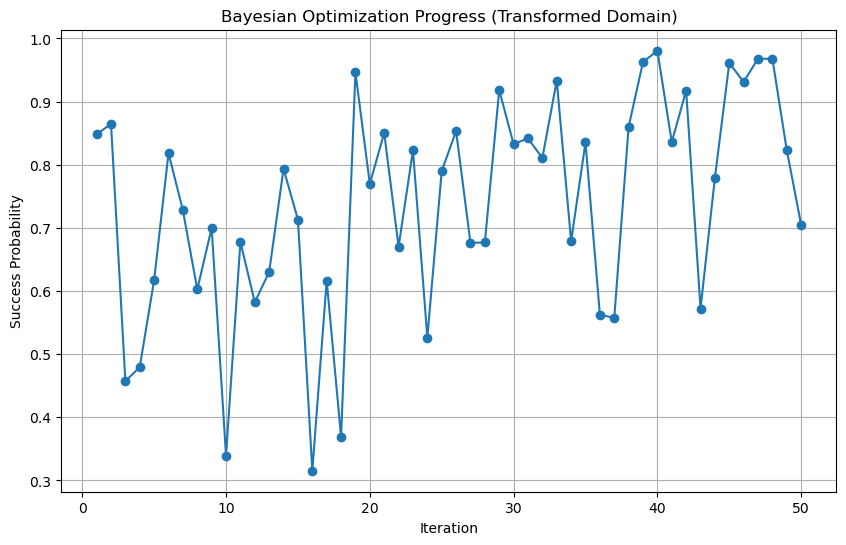

[Debug] Baseline feature vector (transformed): num__release_ball_direction_x   -0.211170
num__release_ball_direction_z    0.122501
num__release_ball_direction_y   -0.266427
num__elbow_release_angle        -0.178268
num__elbow_max_angle            -0.042633
num__wrist_release_angle         0.021145
num__wrist_max_angle             0.015353
num__knee_release_angle         -0.042579
num__knee_max_angle             -0.013361
num__release_ball_speed         -0.222058
num__calculated_release_angle    0.723091
num__release_ball_velocity_x    -0.207910
num__release_ball_velocity_y    -0.185908
num__release_ball_velocity_z    -0.244303
dtype: float64
[Debug] Baseline DataFrame columns: ['num__release_ball_direction_x', 'num__release_ball_direction_z', 'num__release_ball_direction_y', 'num__elbow_release_angle', 'num__elbow_max_angle', 'num__wrist_release_angle', 'num__wrist_max_angle', 'num__knee_release_angle', 'num__knee_max_angle', 'num__release_ball_speed', 'num__calculated_release_angle', 

In [2]:
# %%writefile ml/bayesian_optimization/bayesian_optimized_metrics.py
# previously: %%writefile ../../src/freethrow_predictions/ml/bayes_optim_angles_xgboostpreds.py
import os
from pathlib import Path
import pandas as pd
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import pickle

# Import the early stopping callback from skopt
from skopt.callbacks import DeltaYStopper

# Configuration and model utilities
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig
from ml.train_utils.train_utils import load_model

# Updated DataPreprocessor (which now returns X_inversed as part of final_preprocessing)
from datapreprocessor import DataPreprocessor
from ml.feature_selection.feature_importance_calculator import manage_features

# Simple helper for debug prints (logger removed)
def log_debug(message, debug):
    if debug:
        print(message)

def get_preprocessing_results(preprocessor, df, debug):
    """
    Run preprocessing and return X_preprocessed, X_inversed.
    We assume final_preprocessing returns: X_preprocessed, recommendations, X_inversed.
    """
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df)
        log_debug(f"[Debug] Preprocessing complete. X_preprocessed shape: {X_preprocessed.shape}", debug)
        return X_preprocessed, X_inversed
    except Exception as e:
        log_debug(f"[Error] Preprocessing failed: {e}", debug)
        raise

def compute_real_ranges(X_inversed, optimization_columns, debug):
    """
    Compute the min and max for each optimization column from X_inversed (real domain).
    """
    real_ranges = {}
    for col in optimization_columns:
        # Here we assume that the column names in X_inversed are the original names.
        real_min = float(X_inversed[col].min())
        real_max = float(X_inversed[col].max())
        real_ranges[col] = (real_min, real_max)
    log_debug(f"[Debug] Computed optimization ranges (real domain): {real_ranges}", debug)
    return real_ranges

def map_transformed_to_real(candidate_val, trans_range, real_range):
    """
    Given a candidate value in the transformed domain, linearly map it into
    the real domain using the provided ranges.
    
    Parameters:
      - candidate_val: a value in the transformed domain
      - trans_range: (min, max) tuple from X_preprocessed
      - real_range: (min, max) tuple from X_inversed
      
    Returns:
      The candidate value mapped into the real domain.
    """
    trans_min, trans_max = trans_range
    real_min, real_max = real_range
    # Avoid division by zero by checking if trans_max == trans_min.
    if trans_max == trans_min:
        return real_min
    # Linear mapping formula:
    real_val = real_min + ((candidate_val - trans_min) / (trans_max - trans_min)) * (real_max - real_min)
    return real_val


def compute_optimization_ranges(X_transformed, optimization_columns, debug):
    """
    Compute the min and max for each optimization column from X_transformed.
    If a transformed feature has a prefix (e.g., 'num__'), use that column.
    """
    ranges = {}
    for col in optimization_columns:
        # Determine the key in the transformed data
        transformed_col = f"num__{col}" if f"num__{col}" in X_transformed.columns else col
        ranges[col] = (float(X_transformed[transformed_col].min()), float(X_transformed[transformed_col].max()))
    log_debug(f"[Debug] Computed optimization ranges (transformed domain): {ranges}", debug)
    return ranges

def define_search_space(opt_ranges, optimization_columns, debug):
    """
    Define the search space for Bayesian optimization using ranges from X_transformed.
    """
    missing = [col for col in optimization_columns if col not in opt_ranges]
    if missing:
        raise KeyError(f"Missing columns in optimization ranges: {missing}")
    space = [Real(opt_ranges[col][0], opt_ranges[col][1], name=col) for col in optimization_columns]
    log_debug(f"[Debug] Defined search space: {space}", debug)
    return space



def get_model_feature_order(model):
    if hasattr(model, "get_booster"):
        # XGBoost case
        return model.get_booster().feature_names
    elif hasattr(model, "feature_names_"):
        # CatBoost case
        return model.feature_names_
    else:
        raise AttributeError("The model does not have a known attribute for feature names.")

def objective(params, optimization_columns, X_preprocessed, model, debug):
    # Create the baseline feature vector by taking the mean of X_preprocessed
    feature_vector = X_preprocessed.mean(axis=0).copy()
    
    if debug:
        print("[Debug] Columns in X_preprocessed.mean(axis=0):", feature_vector.index.tolist())
    
    # Update features with candidate parameter values
    for col, value in zip(optimization_columns, params):
        transformed_col = f"num__{col}"
        if transformed_col in feature_vector.index:
            print(f"[Debug] Updating {transformed_col} with value {value}")
            feature_vector[transformed_col] = value
        else:
            print(f"[Debug] Warning: {transformed_col} not found in feature_vector!")
    
    if debug:
        print("[Debug] Columns in feature_vector after assignment:", feature_vector.index.tolist())
    
    # Convert to DataFrame
    feature_df = pd.DataFrame([feature_vector])
    
    # Get the expected feature order using our helper function
    expected_feature_order = get_model_feature_order(model)
    if debug:
        print("[Debug] Expected feature order:", expected_feature_order)
        print("[Debug] Feature DataFrame columns before reindex:", feature_df.columns.tolist())
    
    feature_df = feature_df.reindex(columns=expected_feature_order)
    
    if debug:
        print("[Debug] Feature DataFrame columns after reindex:", feature_df.columns.tolist())
    
    # Get success probability
    success_prob = model.predict_proba(feature_df)[0, 1]
    if debug:
        print(f"[Debug] Objective with params {params}: success_prob = {success_prob:.4f}")
    return -success_prob



def perform_optimization(wrapper_objective, search_space, n_calls, debug,
                         delta_threshold=0.005, n_best=3):  # adjusted values
    """
    Run gp_minimize with the wrapped objective and search space.
    Adds early stopping via a callback if improvement is below delta_threshold
    for n_best iterations.
    """
    stopper = DeltaYStopper(delta=delta_threshold, n_best=n_best)
    callbacks = [stopper]

    result = gp_minimize(func=wrapper_objective, 
                         dimensions=search_space, 
                         n_calls=n_calls, 
                         random_state=42,
                         callback=callbacks)

    if debug:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(result.func_vals) + 1), [-val for val in result.func_vals], marker='o')
        plt.title("Bayesian Optimization Progress (Transformed Domain)")
        plt.xlabel("Iteration")
        plt.ylabel("Success Probability")
        plt.grid(True)
        plt.show()
    return result



def bayesian_optimization_main(config: AppConfig, delta_threshold: float, n_best: float, n_calls: float, df: pd.DataFrame, debug=False):
    # Your implementation here
    if debug:
        print(f"Delta Threshold: {delta_threshold}, Type: {type(delta_threshold)}")
        print(f"n_best: {n_best}, Type: {type(n_best)}")
        print(f"n_calls: {n_calls}, Type: {type(n_calls)}")
    # ----------------------------
    # Step 1: Extract Configuration Values
    # ----------------------------
    data_dir = Path(config.paths.data_dir).resolve()
    features_file = data_dir / config.paths.features_metadata_file
    model_save_dir = Path(config.paths.model_save_base_dir).resolve()
    transformers_dir = Path(config.paths.transformers_save_base_dir).resolve()
    
    # ----------------------------
    # Step 2: Load Optimization Columns via Feature Assets
    # ----------------------------
    try:
        with open(features_file, 'rb') as f:
            selected_features = pickle.load(f)
        # Allow for either list or DataFrame format.
        if isinstance(selected_features, list):
            optimization_columns = selected_features
        else:
            optimization_columns = selected_features.columns.tolist()
        log_debug(f"[Debug] Loaded optimization columns: {optimization_columns}", debug)
    except Exception as e:
        print(f"[Error] Failed to load selected features: {e}")
        raise

    # Remove y_variable(s) from optimization columns if present.
    y_variables = config.features.y_variable  # List of target variables
    log_debug(f"[Debug] Target variables to remove: {y_variables}", debug)
    for y_var in y_variables:
        if y_var in optimization_columns:
            optimization_columns.remove(y_var)
            log_debug(f"[Debug] Removed '{y_var}' from optimization columns.", debug)
        else:
            log_debug(f"[Debug] '{y_var}' not found in optimization columns.", debug)
    
    log_debug(f"[Debug] Final optimization columns: {optimization_columns}", debug)
    
    # ----------------------------
    # Step 3: Initialize DataPreprocessor Using Column Assets
    # ----------------------------
    paths = config.paths
    feature_paths = {
        'features': Path('../../data/preprocessor/features_info/final_ml_df_selected_features_columns.pkl'),
        'ordinal_categoricals': Path('../../data/preprocessor/features_info/ordinal_categoricals.pkl'),
        'nominal_categoricals': Path('../../data/preprocessor/features_info/nominal_categoricals.pkl'),
        'numericals': Path('../../data/preprocessor/features_info/numericals.pkl'),
        'y_variable': Path('../../data/preprocessor/features_info/y_variable.pkl')
    }

    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
    except Exception as e:
        print(f"[Error] Failed to load feature lists: {e}")
        raise

    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',  # The same mode as in predict pipelines
        options={},
        debug=False,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )

    # ----------------------------
    # Step 4: Preprocess the Data (Transformed Domain)
    # ----------------------------
    X_preprocessed, X_inversed = get_preprocessing_results(preprocessor, df, debug)
    # Compute optimization ranges using X_preprocessed (transformed space)
    opt_ranges = compute_optimization_ranges(X_preprocessed, optimization_columns, debug)
    
    # ----------------------------
    # Step 5: Load the Trained Model
    # ----------------------------
    # For example, load the best model based on tuning info; here we assume you know the best model name.
    trained_model = load_model('CatBoost', model_save_dir)  # Replace with your logic if available

    # ----------------------------
    # Step 6: Define the Search Space and Objective Function
    # ----------------------------
    search_space = define_search_space(opt_ranges, optimization_columns, debug)
    wrapper_objective = lambda params: objective(params, optimization_columns, X_preprocessed, trained_model, debug)

    # ----------------------------
    # Step 7: Perform Bayesian Optimization with Early Stopping
    # ----------------------------
    res = perform_optimization(wrapper_objective, search_space, n_calls=n_calls, debug=debug,
                               delta_threshold=delta_threshold, n_best=n_best)
    params_df = pd.DataFrame(res.x_iters, columns=optimization_columns)
    params_df['success_prob'] = [-val for val in res.func_vals]

    # ----------------------------
    # Step 8: Compare Baseline vs. Optimized (in Transformed Domain)
    # ----------------------------
    # Use the preprocessed (transformed) mean for the baseline.
    baseline_feature_vector = X_preprocessed.mean(axis=0)
    print("[Debug] Baseline feature vector (transformed):", baseline_feature_vector)
    baseline_df = pd.DataFrame([baseline_feature_vector])
    # Use this:
    expected_feature_order = get_model_feature_order(trained_model)
    baseline_df = baseline_df.reindex(columns=expected_feature_order)
    print("[Debug] Baseline DataFrame columns:", baseline_df.columns.tolist())
    baseline_success = trained_model.predict_proba(baseline_df)[0, 1]

    print(f"[Debug] Baseline success probability: {baseline_success:.4f}")

    # ----- Step 8: Comparison using Real Numbers -----

    # (A) Compute the baseline (real) values using X_inversed.
    baseline_real = {}
    for col in optimization_columns:
        baseline_real[col] = X_inversed[col].mean()
    baseline_real_series = pd.Series(baseline_real)

    # (B) Compute candidate (optimized) parameters in the real domain.
    # We already have candidate values (res.x) in the transformed domain.
    real_ranges = compute_real_ranges(X_inversed, optimization_columns, debug)
    candidate_real = {}
    for col, cand_val in zip(optimization_columns, res.x):
        trans_range = opt_ranges[col]  # from transformed X_preprocessed
        candidate_real[col] = map_transformed_to_real(cand_val, trans_range, real_ranges[col])
    candidate_real_series = pd.Series(candidate_real)

    # (C) Build the parameter comparison table
    min_values_real = [real_ranges[col][0] for col in optimization_columns]
    max_values_real = [real_ranges[col][1] for col in optimization_columns]

    comparison_real = pd.DataFrame({
        "Parameter": optimization_columns,
        "Baseline (Real)": baseline_real_series.values,
        "Optimized (Candidate, Real)": candidate_real_series.values,
        "Difference": candidate_real_series.values - baseline_real_series.values,
        "Min (Real)": min_values_real,
        "Max (Real)": max_values_real
    })

    # (D) Compute success rates from the model.
    baseline_success = trained_model.predict_proba(pd.DataFrame([X_preprocessed.mean(axis=0)]))[0, 1]
    candidate_success = -res.fun  # recall objective returns negative success probability

    # Instead of appending a separate row, add new columns for the success rates.
    comparison_real["Success Rate (Baseline)"] = baseline_success
    comparison_real["Success Rate (Candidate)"] = candidate_success
    comparison_real["Success Rate Diff"] = candidate_success - baseline_success

    print("Comparison of Baseline vs. Optimized Parameters (Real Domain):")
    print(comparison_real)
    
    # save the results to data\predictions\bayesian_optimization_results
    output_dir = Path(config.paths.predictions_output_dir).resolve() / 'bayesian_optimization_results'
    comparison_real.to_csv(output_dir / 'bayesian_optimization_results.csv', index=False)

    return comparison_real

if __name__ == "__main__":
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
        print(f"Config loaded from {config_path}")
    except Exception as e:
        print("Failed to load config:", e)
        exit(1)
    
    data_dir = Path(config.paths.data_dir).resolve()
    df_path = data_dir / config.paths.raw_data
    df = pd.read_csv(df_path)
    
    results = bayesian_optimization_main(config, 
                                         delta_threshold=0.001, # the minimum improvement (change in the objective value) that must be observed for the optimizer to consider a new candidate as “better.”
                                         n_best=5, #the number of successive iterations that are compared to decide if the improvement is below the delta_threshold.
                                         n_calls=50, #maximum number of function evaluations (iterations) that the optimization algorithm will perform.
                                         df=df, 
                                         debug=True)
